### Libraries and data loading

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import datetime
import itertools
import h5py
import math
import matplotlib.dates as mdates
import numpy.ma as ma
import CRPS.CRPS as pscore
from torch.utils.data import Dataset
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.image as mpimg
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from sklearn.model_selection import KFold
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
import gc
import pickle as pkl
#import tables
import hdf5plugin
#writer = SummaryWriter()

%matplotlib inline
#%load_ext tensorboard

In [2]:
import torch
print(torch.__version__)
# Check if CUDA is available
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
print(f"GPU count: {torch.cuda.device_count()}")

# Get GPU name
if torch.cuda.is_available():
    print(f"GPU name: {torch.cuda.get_device_name(0)}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


2.7.1+cu128
CUDA available: True
CUDA version: 12.8
GPU count: 1
GPU name: NVIDIA GeForce RTX 4070 Ti


In [3]:
sunny_day = [(2017,9,15),(2017,10,6),(2017,10,22),(2018,2,16),(2018,6,12),(2018,6,23),(2019,1,25),(2019,6,23),(2019,7,14),(2019,10,14)]
cloudy_day = [(2017,6,24),(2017,9,20),(2017,10,11),(2018,1,25),(2018,3,9),(2018,10,4),(2019,5,27),(2019,6,28),(2019,8,10),(2019,10,19)]

sunny_datetime = [datetime.datetime(day[0],day[1],day[2]) for day in sunny_day]
cloudy_datetime = [datetime.datetime(day[0],day[1],day[2]) for day in cloudy_day]
test_dates = sunny_datetime + cloudy_datetime

In [4]:
test_dates

[datetime.datetime(2017, 9, 15, 0, 0),
 datetime.datetime(2017, 10, 6, 0, 0),
 datetime.datetime(2017, 10, 22, 0, 0),
 datetime.datetime(2018, 2, 16, 0, 0),
 datetime.datetime(2018, 6, 12, 0, 0),
 datetime.datetime(2018, 6, 23, 0, 0),
 datetime.datetime(2019, 1, 25, 0, 0),
 datetime.datetime(2019, 6, 23, 0, 0),
 datetime.datetime(2019, 7, 14, 0, 0),
 datetime.datetime(2019, 10, 14, 0, 0),
 datetime.datetime(2017, 6, 24, 0, 0),
 datetime.datetime(2017, 9, 20, 0, 0),
 datetime.datetime(2017, 10, 11, 0, 0),
 datetime.datetime(2018, 1, 25, 0, 0),
 datetime.datetime(2018, 3, 9, 0, 0),
 datetime.datetime(2018, 10, 4, 0, 0),
 datetime.datetime(2019, 5, 27, 0, 0),
 datetime.datetime(2019, 6, 28, 0, 0),
 datetime.datetime(2019, 8, 10, 0, 0),
 datetime.datetime(2019, 10, 19, 0, 0)]

In [6]:
# define the data location and load data
import os
preprocessing_folder = "D:/PVOutputPrediction/preprocessing/"
cwd = os.getcwd()
#pardir = os.path.dirname(os.path.dirname(cwd))
data_folder = os.path.join(preprocessing_folder,"data")
#data_path = os.path.join(data_folder,'video_prediction_224_second.h5')

# !change model name for different models!
model_name = 'UNet_sky_image_PV_mapping'
output_folder = os.path.join(cwd,"model_output", model_name)
if os.path.isdir(output_folder)==False:
    os.makedirs(output_folder)

image_name_format = '%Y%m%d%H%M%S'

# Operating parameter
stack_height = 15 # 15 minute
forecast_horizon = 15 # 15 minutes ahead forecast
sampling_interval_all = [2]
output_img_shape = [224, 224, 3]

print("data_folder:", data_folder)
#print("data_path:", data_path)
print("output_folder:", output_folder)

data_folder: D:/PVOutputPrediction/preprocessing/data
output_folder: d:\PVOutputPrediction\models\model_output\UNet_sky_image_PV_mapping


In [6]:
#print(pardir)


In [7]:
# import h5py
# with h5py.File(data_path, 'r') as f:
    # Access the dataset directly by its path
    # This creates a dataset object, but does not load the data yet
    # print(f["trainval"])
    
    # Use slicing to load the data into a NumPy array
    
    
    #print(f"Dataset shape: {dataset.shape}")
    #print(f"Data type: {dataset.dtype}")
    #print(f"First 5 rows:\n{data_array[:5]}")

In [8]:
data_path = "../preprocessing/data/video_prediction_224_testing.h5"
f = h5py.File(data_path, 'r')
image_log_trainval = f['trainval/image_log']
image_log_test = f['test/image_log']


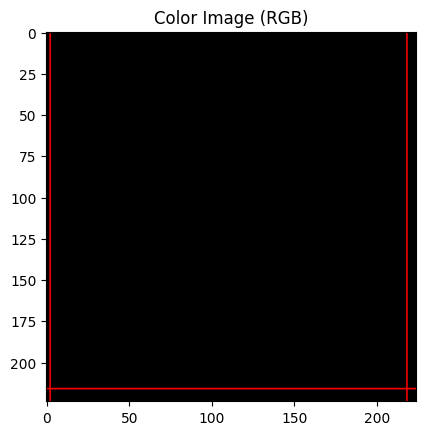

In [16]:
image = image_log_test[0][15]
#image = image[90:130, :20]
image[:,2] = [255,0,0]
image[:,-6] = [255,0,0]
image[0,:] = [255,0,0]
image[-8,:] = [255,0,0]
plt.imshow(image)
plt.title("Color Image (RGB)")
plt.show()

In [ ]:
print(image[0,110])

[51 43 54]


In [ ]:
# generate handler for the hdf5 data
forecast_dataset = h5py.File(data_path, 'r')

# show structure of the hdf5 data
def get_all(name):
    if name!=None:
        print(forecast_dataset[name])

forecast_dataset.visit(get_all)

<HDF5 group "/test" (3 members)>
<HDF5 dataset "image_log": shape (6145, 16, 224, 224, 3), type "|u1">
<HDF5 dataset "pv_log": shape (6145, 16), type "<f8">
<HDF5 dataset "pv_pred": shape (6145,), type "<f8">
<HDF5 group "/trainval" (3 members)>
<HDF5 dataset "image_log": shape (149680, 16, 224, 224, 3), type "|u1">
<HDF5 dataset "pv_log": shape (149680, 16), type "<f8">
<HDF5 dataset "pv_pred": shape (149680,), type "<f8">


In [7]:
n_samples = 317968

In [ ]:
'''import hdf5plugin
chunk_shape = (1, stack_height+1, *output_img_shape)

batch_size = 8000
with h5py.File('dummyfile.h5', 'w') as f:

	#image_log = f.create_dataset('image_log', shape = (n_images, 224, 224, 3), dtype ='uint8', )

        # First run - create new datasets

	trainval_group = f.create_group('trainval')
	test_group = f.create_group('test')
	image_log_trainval_ds = trainval_group.create_dataset(
		'image_log',
		shape=(5, stack_height+1, *output_img_shape),
		chunks=chunk_shape,
		compression=hdf5plugin.Blosc2(cname='zstd', clevel=1, filters=hdf5plugin.Blosc2.SHUFFLE),
		dtype='uint8'
	)

	print("Creating new datasets")
	for i in range(4):
		image_log_trainval_ds[i:i+1] = np.ones((1, stack_height+1, *output_img_shape), dtype='uint8')
		f.flush()'''

Creating new datasets


In [ ]:
# from datasets import load_dataset

# ds = load_dataset("skyimagenet/SKIPPD")

# images_train =[]
# pv_train = []
# times_train = []
# images_test =[]
# pv_test = []
# times_test = []
# for mode in ["train", "test"]:
    # globals()[f'images_{mode}'].append(np.array(ds[mode][:]['image']))
    # globals()[f'pv_{mode}'].append(ds[mode][:]['pv'])
    # globals()[f'times_{mode}'] = ds[mode][:]['time']

# for mode in ["train", "test"]:
#     globals()[f'images_{mode}'] = np.array(globals()[f'images_{mode}'])
#     globals()[f'pv_{mode}'] = np.array(globals()[f'pv_{mode}'] )
    
# images_train = np.squeeze(images_train)
# pv_train = np.squeeze(pv_train)
# times_train = np.squeeze(times_train)

# images_test = np.squeeze(images_test)
# pv_test = np.squeeze(pv_test)
# times_test = np.squeeze(times_test)

In [ ]:
# np.save("times_train.npy", np.array(times_train))
# np.save("times_test.npy", np.array(times_test))

In [9]:
def varpath(txt):
    return(os.path.join("variables", txt))

In [10]:
os.chdir('..')
images_trainval = np.load(varpath("images_trainval.npy"))
pv_trainval = np.load(varpath("pv_trainval.npy"))
times_trainval = np.load(varpath("times_trainval.npy"), allow_pickle=True)

# images_test = np.load("images_test.npy")
# pv_test = np.load("pv_test.npy")
# times_test = np.load("times_test.npy", allow_pickle=True)

images_trainval = images_trainval.transpose(0, 3, 1, 2)
# images_test = images_test.transpose(0, 3, 1, 2)
images_trainval = torch.from_numpy(images_trainval).float()
# images_test = torch.from_numpy(images_test).float()
pv_trainval = torch.from_numpy(pv_trainval).float()
# pv_test = torch.from_numpy(pv_test).float()
times_trainval = np.squeeze(times_trainval)
# times_test = np.squeeze(times_test)


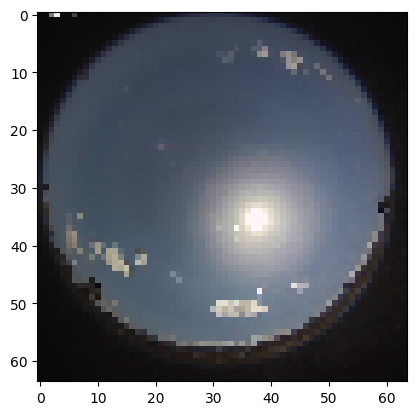

tensor(23.2777)


In [31]:
idx = 2000
img = images_trainval[idx]

# If it's a tensor, convert to numpy
if torch.is_tensor(img):
	img = img.cpu().numpy()

# Transpose from (C, H, W) to (H, W, C) for matplotlib
arr = np.transpose(img, (1, 2, 0))

# Ensure values are in the correct range [0, 1] or [0, 255]
# If your values are in [0, 255] range but stored as float, convert to uint8
if arr.max() > 1.0:
    arr = arr.astype(np.uint8)
else:
    # If normalized to [0, 1], matplotlib handles it automatically
    pass
plt.imshow(arr, cmap=None, interpolation=None, aspect=None)

plt.show()

print(pv_trainval[idx])

### Input data pipeline helper functions

In [8]:
# day block shuffling of the time stamps, and return shuffled indices
def day_block_shuffle(times_trainval):

    # Only keep the date of each time point
    dates_trainval = np.zeros_like(times_trainval, dtype=datetime.date)
    for i in range(len(times_trainval)):
        dates_trainval[i] = times_trainval[i].date()

    # Chop the indices into blocks, so that each block contains the indices of the same day
    unique_dates = np.unique(dates_trainval)
    blocks = []
    for i in range(len(unique_dates)):
        blocks.append(np.where(dates_trainval == unique_dates[i])[0])

    # shuffle the blocks, and chain it back together
    np.random.seed(1)
    np.random.shuffle(blocks)
    shuffled_indices = np.asarray(list(itertools.chain.from_iterable(blocks)))

    return shuffled_indices

In [9]:
# a cross validation generator function for spliting the dayblock shuffled indices into training and validation
def cv_split(split_data, fold_index, num_fold):
    '''
    input:
    split_data: the dayblock shuffled indices to be splitted
    fold_index: the ith fold chosen as the validation, used for generating the seed for random shuffling
    num_fold: N-fold cross validation
    output:
    data_train: the train data indices
    data_val: the validation data indices
    '''
    # randomly divides into a training set and a validation set
    num_samples = len(split_data)
    indices = np.arange(num_samples)

    # finding training and validation indices
    val_mask = np.zeros(len(indices), dtype=bool)
    val_mask[int(fold_index / num_fold * num_samples):int((fold_index + 1) / num_fold * num_samples)] = True
    val_indices = indices[val_mask]
    train_indices = indices[np.logical_not(val_mask)]

    # shuffle indices
    np.random.seed(fold_index)
    np.random.shuffle(train_indices)
    np.random.shuffle(val_indices)

    data_train = split_data[train_indices]
    data_val = split_data[val_indices]

    return data_train,data_val

In [10]:
def mask_background(img, img_size = 224): # put all background pixels (the ones outside the circle region of sky images) to 0s
	mask = torch.ones((3,img_size,img_size), dtype=bool)

	if img_size == 224:
		center_i = 108
		center_j = 110
		radius = 108
	elif img_size == 64:
		center_i = 30
		center_j = 30
		radius = 31
	for i in range(img_size):
		for j in range(img_size):
			if (i-center_i)**2+(j-center_j)**2>=radius**2:
				mask[:,i,j]=0
	mask_img = img*mask
	return mask_img

In [11]:
class PVDataset(Dataset):

    def __init__(self, images, pv, transform=None, target_transform=None):
        """
        Arguments:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.images = mask_background(images)
        self.images = self.images/255
        self.pv = pv

        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):

        image = self.images[idx]
        pv = self.pv[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            pv = self.target_transform(pv)
        return image, pv

In [12]:
def compute_winkler_score(prob_prediction,observation):
    alpha = 0.1
    lb = np.percentile(prob_prediction,5,axis=0)
    ub = np.percentile(prob_prediction,95,axis=0)
    delta = ub-lb
    if observation<lb:
        sc = delta+2*(lb-observation)/alpha
    if observation>ub:
        sc = delta+2*(observation-ub)/alpha
    if (observation>=lb) and (observation<=ub):
        sc = delta
    return sc

### Model architecture

In [13]:
# define training time parameters
num_filters = 12
num_epochs = 200 #(The maximum epoches set to 200 and there might be early stopping depends on validation loss)
num_fold = 10 # 10-fold cross-validation
batch_size = 256
val_batch_size = 512

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import timm

#model = timm.create_model("hf_hub:timm/convnext_tiny.in12k", pretrained=True)

'''class ViT(nn.Module):
    """
    U-Net style architecture for Image-to-PV prediction
    """
    def __init__(self, image_input_dim, num_filters=12):
        super(ViT, self).__init__()

        # Assuming image_input_dim is (height, width, channels)
        # PyTorch uses (channels, height, width)
        if len(image_input_dim) == 3:
            input_channels = image_input_dim[0]  # Assuming CHW format
        else:
            input_channels = image_input_dim[2]  # Assuming HWC format

        # Initial 1x1 convolution
        self.conv1x1_input = nn.Conv2d(input_channels, num_filters, kernel_size=1, padding=0)

        # Encoder (contracting path)
        self.conv3x3_1 = Conv3x3Block(num_filters, num_filters)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3x3_2 = Conv3x3Block(num_filters, 2 * num_filters)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3x3_3 = Conv3x3Block(2 * num_filters, 4 * num_filters)

        # Bottleneck with residual blocks
        self.bottleneck1 = BottleNeckBlock(4 * num_filters)
        self.bottleneck2 = BottleNeckBlock(4 * num_filters)

        # Decoder (expanding path)
        self.up1 = Up2x2Conv3x3(4 * num_filters, 2 * num_filters)
        self.conv3x3_4 = Conv3x3Block(4 * num_filters, 2 * num_filters)  # After concatenation
        self.dropout1 = nn.Dropout2d(0.4)

        self.up2 = Up2x2Conv3x3(2 * num_filters, num_filters)
        self.conv3x3_5 = Conv3x3Block(2 * num_filters, num_filters)  # After concatenation
        self.dropout2 = nn.Dropout2d(0.4)

        # Final 1x1 convolution and output
        self.conv1x1_output = nn.Conv2d(num_filters, 1, kernel_size=1, padding=0)
        self.relu_final = nn.ReLU(inplace=True)

        # Global average pooling and final dense layer
        self.flatten = nn.Flatten()
        self.final_dense = nn.Linear(4096, 1)

    def forward(self, x):
        # Initial 1x1 convolution
        x = self.conv1x1_input(x)

        # Encoder path
        # First level
        skip1 = self.conv3x3_1(x)  # Save for skip connection
        x = self.maxpool1(skip1)

        # Second level
        skip2 = self.conv3x3_2(x)  # Save for skip connection
        x = self.maxpool2(skip2)

        # Third level
        x = self.conv3x3_3(x)

        # Bottleneck
        x = self.bottleneck1(x)
        x = self.bottleneck2(x)

        # Decoder path
        # First upsampling
        x = self.up1(x)
        x = torch.cat([x, skip2], dim=1)  # Concatenate along channel dimension
        x = self.conv3x3_4(x)
        x = self.dropout1(x)

        # Second upsampling
        x = self.up2(x)
        x = torch.cat([x, skip1], dim=1)  # Concatenate along channel dimension
        x = self.conv3x3_5(x)
        x = self.dropout2(x)

        # Final output
        x = self.conv1x1_output(x)
        x = self.relu_final(x)

        # Global pooling and final prediction
        x = self.flatten(x)
        x = self.final_dense(x)

        return x

# Example instantiation and summary
if __name__ == "__main__":
    # Assuming 64x64 RGB images
    model = ViT(image_input_dim=(3, 64, 64), num_filters=num_filters).to(device)
    
    # Print model summary
    print(model)

    # Test with dummy input
    dummy_input = torch.randn(1, 3, 64, 64).to(device)  # Batch size 1, 3 channels, 64x64
    output = model(dummy_input)
    print(f"Output shape: {output.shape}")

    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")

    summary(model, input_size = (3,64,64))'''

'class ViT(nn.Module):\n    """\n    U-Net style architecture for Image-to-PV prediction\n    """\n    def __init__(self, image_input_dim, num_filters=12):\n        super(ViT, self).__init__()\n\n        # Assuming image_input_dim is (height, width, channels)\n        # PyTorch uses (channels, height, width)\n        if len(image_input_dim) == 3:\n            input_channels = image_input_dim[0]  # Assuming CHW format\n        else:\n            input_channels = image_input_dim[2]  # Assuming HWC format\n\n        # Initial 1x1 convolution\n        self.conv1x1_input = nn.Conv2d(input_channels, num_filters, kernel_size=1, padding=0)\n\n        # Encoder (contracting path)\n        self.conv3x3_1 = Conv3x3Block(num_filters, num_filters)\n        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)\n\n        self.conv3x3_2 = Conv3x3Block(num_filters, 2 * num_filters)\n        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)\n\n        self.conv3x3_3 = Conv3x3Block(2 * num_filters, 

In [16]:
def trainval(model, device, loader, optimizer, criterion, mode="train"):
    
    if mode == "train":
        model.train()
    else:
        model.eval()
        
    size = len(loader)
         
    total_loss = 0
    for batch_idx, (image,pv) in enumerate(loader):
        image, pv = image.to(device), pv.to(device)
        
        output = model(image).squeeze()
        loss = criterion(output, pv)
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        total_loss += loss.item()
        
    total_loss = total_loss / size
    return total_loss

In [17]:
# import timm

# model = timm.create_model("hf_hub:timm/convnext_tiny.in12k", pretrained=True)
# model.head.fc = nn.Linear(768, 1)
# model.to(device)
# summary(model, input_size = (3, 64, 64))

In [18]:
class Conv3x3Block(nn.Module):
    """
    Basic convolutional block with Conv2D -> BatchNorm -> ReLU
    """
    def __init__(self, input_channels, output_channels):
        super(Conv3x3Block, self).__init__()
        self.conv = nn.Conv2d(input_channels, output_channels, kernel_size=3, padding=1)
        self.bn = nn.BatchNorm2d(output_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

class BottleNeckBlock(nn.Module):
    """
    Residual bottleneck block with skip connection
    """
    def __init__(self, channels):
        super(BottleNeckBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = out + identity  # Skip connection
        return out

class Up2x2Conv3x3(nn.Module):
    """
    Upsampling block with 2x2 upsampling followed by 3x3 convolution
    """
    def __init__(self, input_channels, output_channels):
        super(Up2x2Conv3x3, self).__init__()
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')
        self.conv = nn.Conv2d(input_channels, output_channels, kernel_size=3, padding=1)

    def forward(self, x):
        x = self.upsample(x)
        x = self.conv(x)
        return x

class UNet(nn.Module):
    """
    U-Net style architecture for Image-to-PV prediction
    """
    def __init__(self, image_input_dim, num_filters=12):
        super(UNet, self).__init__()

        # Assuming image_input_dim is (height, width, channels)
        # PyTorch uses (channels, height, width)
        if len(image_input_dim) == 3:
            input_channels = image_input_dim[0]  # Assuming CHW format
        else:
            input_channels = image_input_dim[2]  # Assuming HWC format

        # Initial 1x1 convolution
        self.conv1x1_input = nn.Conv2d(input_channels, num_filters, kernel_size=1, padding=0)

        # Encoder (contracting path)
        self.conv3x3_1 = Conv3x3Block(num_filters, num_filters)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3x3_2 = Conv3x3Block(num_filters, 2 * num_filters)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3x3_3 = Conv3x3Block(2 * num_filters, 4 * num_filters)

        # Bottleneck with residual blocks
        self.bottleneck1 = BottleNeckBlock(4 * num_filters)
        self.bottleneck2 = BottleNeckBlock(4 * num_filters)

        # Decoder (expanding path)
        self.up1 = Up2x2Conv3x3(4 * num_filters, 2 * num_filters)
        self.conv3x3_4 = Conv3x3Block(4 * num_filters, 2 * num_filters)  # After concatenation
        self.dropout1 = nn.Dropout2d(0.4)

        self.up2 = Up2x2Conv3x3(2 * num_filters, num_filters)
        self.conv3x3_5 = Conv3x3Block(2 * num_filters, num_filters)  # After concatenation
        self.dropout2 = nn.Dropout2d(0.4)

        # Final 1x1 convolution and output
        self.conv1x1_output = nn.Conv2d(num_filters, 1, kernel_size=1, padding=0)
        self.relu_final = nn.ReLU(inplace=True)

        # Global average pooling and final dense layer
        self.flatten = nn.Flatten()
        self.final_dense = nn.Linear(4096, 1)

    def forward(self, x):
        # Initial 1x1 convolution
        x = self.conv1x1_input(x)

        # Encoder path
        # First level
        skip1 = self.conv3x3_1(x)  # Save for skip connection
        x = self.maxpool1(skip1)

        # Second level
        skip2 = self.conv3x3_2(x)  # Save for skip connection
        x = self.maxpool2(skip2)

        # Third level
        x = self.conv3x3_3(x)

        # Bottleneck
        x = self.bottleneck1(x)
        x = self.bottleneck2(x)

        # Decoder path
        # First upsampling
        x = self.up1(x)
        x = torch.cat([x, skip2], dim=1)  # Concatenate along channel dimension
        x = self.conv3x3_4(x)
        x = self.dropout1(x)

        # Second upsampling
        x = self.up2(x)
        x = torch.cat([x, skip1], dim=1)  # Concatenate along channel dimension
        x = self.conv3x3_5(x)
        x = self.dropout2(x)

        # Final output
        x = self.conv1x1_output(x)
        x = self.relu_final(x)

        # Global pooling and final prediction
        x = self.flatten(x)
        x = self.final_dense(x)

        return x

# # Example instantiation and summary
# if __name__ == "__main__":
#     # Assuming 64x64 RGB images
#     model = UNet(image_input_dim=(3, 64, 64), num_filters=num_filters).to(device)
    
#     # Print model summary
#     print(model)

#     # Test with dummy input
#     dummy_input = torch.randn(1, 3, 64, 64).to(device)  # Batch size 1, 3 channels, 64x64
#     output = model(dummy_input)
#     print(f"Output shape: {output.shape}")

#     # Count parameters
#     total_params = sum(p.numel() for p in model.parameters())
#     trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
#     print(f"Total parameters: {total_params:,}")
#     print(f"Trainable parameters: {trainable_params:,}")

#     summary(model, input_size = (3,64,64))
    

In [19]:
criterion = nn.MSELoss()
initial_learning_rate = 2e-4
#optimizer = optim.Adam(model.parameters(), lr = initial_learning_rate)

def checkpoint(model, filename):
	torch.save(model.state_dict(), filename)

def resume(model, filename):
	model.load_state_dict(torch.load(filename))

#scheduler = lr_scheduler.ExponentialLR(optimizer, 0.933)

indices_dayblock_shuffled = day_block_shuffle(times_trainval)

#train_loss_hist = np.load(os.path.join(output_folder,'train_loss_hist.npy'))
#val_loss_hist = np.load(os.path.join(output_folder,'val_loss_hist.npy'))
train_loss_hist = []
val_loss_hist = []


In [ ]:
resume_model = False

if resume_model:
	with open(varpath('min_loss.pkl'), 'rb') as file:
		min_loss = pkl.load(file)
else:
	min_loss = [10000] * num_fold
	start_fold = 1

In [ ]:
#load_weights = True

for i in range (start_fold if 'start_fold' in globals() else 1, num_fold+1): # 1-indexing

	
	gc.collect()
	torch.cuda.empty_cache()
	model = timm.create_model("hf_hub:timm/convnext_tiny.in12k", pretrained=True)
	model.head.fc = nn.Linear(768, 1)
	model.to(device)
	
	#model = UNet(image_input_dim=(3, 64, 64), num_filters=num_filters).to(device)
	optimizer = optim.Adam(model.parameters(), lr = initial_learning_rate)
	scheduler = lr_scheduler.ExponentialLR(optimizer, 0.933)
	
	indices_train, indices_val = cv_split(indices_dayblock_shuffled,i-1,num_fold)
	images_train = images_trainval[indices_train]
	pv_train = pv_trainval[indices_train]
	images_val = images_trainval[indices_val]
	pv_val = pv_trainval[indices_val]

	train = PVDataset(images_train, pv_train)	
	val = PVDataset(images_val, pv_val)
	train_loader = DataLoader(train, batch_size=batch_size, shuffle=False)
	val_loader = DataLoader(val, batch_size=val_batch_size, shuffle=False)

	train_loss_current = []
	val_loss_current = []
	patience = 0

	for j in range(num_epochs):
		
		if j==0:
			print("initial val loss: ", trainval(model, device, val_loader, optimizer, criterion, mode="val"))

		loss = trainval(model, device, train_loader, optimizer, criterion, mode="train")
		train_loss_current.append(loss)
			

		print(f"Fold {i}; Epoch {j}: Training Loss = ", loss, )

		#if (j % 5 == 0 or j == num_epochs-1):
		loss = trainval(model, device, val_loader, optimizer, criterion, mode="val")
		if j > 10:
			if loss > min_loss[i-1]:
				patience += 1
				if patience == 15:
					print(f"Fold {i}; Loss stopped decreasing, stopping training.")
					break
		if loss < min_loss[i-1]:
			min_loss[i-1] = loss
			patience = 0
			checkpoint(model, "repetitions/best_" + model.__class__.__name__ + "model_repetition_" + str(i) + ".pth")
		val_loss_current.append(loss)
		

		print(f"Fold {i}; Epoch {j}: Val Loss = ", loss, )
		scheduler.step()
	train_loss_hist.append(train_loss_current)
	val_loss_hist.append(val_loss_current)
	plt.plot(train_loss_hist[i-1],label='train')
	plt.plot(val_loss_hist[i-1],label='validation')
	plt.legend()
	plt.show()

	del model, optimizer

initial val loss:  203.06669771498528
Fold 1; Epoch 0: Training Loss =  6.368630548043402
Fold 1; Epoch 0: Val Loss =  6.252595977506775
Fold 1; Epoch 1: Training Loss =  3.5125728511926697
Fold 1; Epoch 1: Val Loss =  7.1060785625291905
Fold 1; Epoch 2: Training Loss =  3.1112700670690825
Fold 1; Epoch 2: Val Loss =  6.990498957426651
Fold 1; Epoch 3: Training Loss =  2.900419053069162
Fold 1; Epoch 3: Val Loss =  7.26374103711999
Fold 1; Epoch 4: Training Loss =  2.576978204888576
Fold 1; Epoch 4: Val Loss =  7.715039502019468
Fold 1; Epoch 5: Training Loss =  2.206390385078744
Fold 1; Epoch 5: Val Loss =  7.901738270469334
Fold 1; Epoch 6: Training Loss =  1.8497705887836398
Fold 1; Epoch 6: Val Loss =  7.878121458965799
Fold 1; Epoch 7: Training Loss =  1.6356828667653878
Fold 1; Epoch 7: Val Loss =  8.690351119939832
Fold 1; Epoch 8: Training Loss =  1.5299624581953877
Fold 1; Epoch 8: Val Loss =  8.02236717334692
Fold 1; Epoch 9: Training Loss =  1.4416183187308789
Fold 1; Epoch 

KeyboardInterrupt: 

In [24]:
print(patience)

14


In [ ]:
import pickle as pkl
with open(varpath('train_loss_hist.pkl'), 'wb') as file:
    pkl.dump(train_loss_hist, file)
with open(varpath('val_loss_hist.pkl'), 'wb') as file:
    pkl.dump(val_loss_hist, file)
with open(varpath('min_loss.pkl'), 'wb') as file:
    pkl.dump(min_loss, file)

In [ ]:
del indices_train, indices_val
del images_train
del pv_train
del images_val
del pv_val
del train
del val
del train_loader
del val_loader

In [ ]:

images_test = np.load(varpath("images_test.npy"))
pv_test = np.load(varpath("pv_test.npy"))
times_test = np.load(varpath("times_test.npy"), allow_pickle=True)

images_test = images_test.transpose(0, 3, 1, 2)

images_test = torch.from_numpy(images_test).float()

pv_test = torch.from_numpy(pv_test).float()

times_test = np.squeeze(times_test)


### Model training and validation

In [ ]:
def plot_lr(history):
    learning_rate = history.history['lr']
    epochs = range(1, len(learning_rate) + 1)
    plt.plot(epochs, learning_rate)
    plt.title('Learning rate')
    plt.xlabel('Epochs')
    plt.ylabel('Learning rate')
    plt.show()

In [ ]:
# Display image and label.
#train_features, train_labels = next(iter(train_loader))
#print(train_labels.dtype)
#print(f"Feature batch shape: {train_features.size()}")
#print(f"Labels batch shape: {train_labels.size()}")
#img = train_features[0].squeeze()
#label = train_labels[0]
#plt.imshow(img.transpose(1,2,0), cmap="gray")
#plt.show()
#print(f"Label: {label}")

#print(img.dtype)

torch.float64
Feature batch shape: torch.Size([128, 3, 64, 64])
Labels batch shape: torch.Size([128])


In [46]:
# summary of training and validation results
best_train_loss_MSE = np.zeros(num_fold)
best_val_loss_MSE = np.zeros(num_fold)

for i in range(num_fold):
    best_val_loss_MSE[i] = np.min(val_loss_hist[i])
    idx = np.argmin(val_loss_hist[i])
    best_train_loss_MSE[i] = train_loss_hist[i][idx]
    print('Model {0}  -- train loss: {1:.2f}, validation loss: {2:.2f} (RMSE)'.format(i+1, np.sqrt(best_train_loss_MSE[i]), np.sqrt(best_val_loss_MSE[i])))
print('The mean train loss (RMSE) for all models is {0:.2f}'.format(np.mean(np.sqrt(best_train_loss_MSE))))
print('The mean validation loss (RMSE) for all models is {0:.2f}'.format(np.mean(np.sqrt(best_val_loss_MSE))))

Model 1  -- train loss: 2.13, validation loss: 2.51 (RMSE)
Model 2  -- train loss: 1.90, validation loss: 1.93 (RMSE)
Model 3  -- train loss: 2.05, validation loss: 1.92 (RMSE)
Model 4  -- train loss: 1.82, validation loss: 2.53 (RMSE)
Model 5  -- train loss: 1.93, validation loss: 2.27 (RMSE)
Model 6  -- train loss: 1.87, validation loss: 2.25 (RMSE)
Model 7  -- train loss: 2.37, validation loss: 2.52 (RMSE)
Model 8  -- train loss: 2.61, validation loss: 2.33 (RMSE)
Model 9  -- train loss: 2.12, validation loss: 1.75 (RMSE)
Model 10  -- train loss: 1.98, validation loss: 2.33 (RMSE)
The mean train loss (RMSE) for all models is 2.08
The mean validation loss (RMSE) for all models is 2.23


In [ ]:
for i in range (1, num_fold+1): # 1-indexing

	del model, optimizer
	gc.collect()
	torch.cuda.empty_cache()
	
	model = UNet(image_input_dim=(3, 64, 64), num_filters=num_filters).to(device)
	optimizer = optim.Adam(model.parameters(), lr = initial_learning_rate)

	test = PVDataset(images_test, pv_test)	
	test_loader = DataLoader(test, batch_size=batch_size, shuffle=False)

	model_path = 'repetitions/' + 'best_model_repetition_'+str(i)+'.pth'
	# load the trained model
	resume(model, model_path)

	loss = trainval(model, device, test_loader, optimizer, criterion, mode="val")

	print(f"Fold {i}: Test Loss = ", loss)
	



Fold 1: Test Loss =  5.8380634540861305
Fold 2: Test Loss =  5.885873394391753
Fold 3: Test Loss =  5.869903418760408
Fold 4: Test Loss =  6.055969829721884
Fold 5: Test Loss =  6.281514589827169
Fold 6: Test Loss =  6.0961378921162
Fold 7: Test Loss =  6.040499654886397
Fold 8: Test Loss =  5.907315125519579
Fold 9: Test Loss =  5.513154856318777
Fold 10: Test Loss =  6.008880087326873


In [58]:
for i in range(0, 1000, 10):
    input = test[i][0].to(device).unsqueeze(0)
    print(model(input))
    print(test[i][1])

tensor([[1.7024]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor(0.0048)
tensor([[2.3459]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor(0.3315)
tensor([[2.5306]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor(0.5194)
tensor([[3.4859]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor(0.8531)
tensor([[3.2123]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor(1.1316)
tensor([[2.0521]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor(1.3022)
tensor([[2.9972]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor(1.6619)
tensor([[3.8655]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor(1.9850)
tensor([[3.5333]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor(2.3075)
tensor([[5.7348]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor(2.6501)
tensor([[3.9446]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor(2.8600)
tensor([[2.9676]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor(4.1890)
tensor([[5.2048]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor(4.9897)

### Model Testing with in-range Test Set

Test set data are 10 cloudy days drawn from 2017 March to 2019 October, which is the same range as the training data set.

#### Feeding Real Future Sky Image

In [ ]:
# load testing data
times_test = np.load(os.path.join(data_folder,"times_curr_test.npy"),allow_pickle=True)
print("times_test.shape:", times_test.shape)

with h5py.File(data_path,'r') as f:

    # read in the data
    images_log_test = f['test']['images_pred'][:,-1]
    pv_log_test = f['test']['pv_pred'][:,-1]

    # normalize image data to [0,1]
    images_data_test = tf.image.convert_image_dtype(images_log_test, dtype=tf.float32).numpy()
    images_data_test = mask_background(images_data_test)
    pv_log_test = tf.convert_to_tensor(pv_log_test, dtype=tf.float32).numpy()

print("images_data_test.shape:",images_data_test.shape)
print("pv_log_test.shape:",pv_log_test.shape)

In [ ]:
# evaluate model on the test set and generate predictions
loss = np.zeros((num_fold,len(times_test)))
prediction = np.zeros((num_fold,len(times_test)))

for i in range(num_fold):
    # define model path
    print("loading repetition {0} model ...".format(i+1))
    model_path = os.path.join(output_folder,'repetition_'+str(i+1),'best_model_repitition_'+str(i+1)+'.h5')
    # load the trained model
    model = keras.models.load_model(model_path)

    # model evaluation
    print("evaluating performance for the model".format(i+1))
    loss[i] = model.evaluate(x=images_data_test, y=pv_log_test, batch_size=256, verbose=1)

    # generate prediction
    print("generating predictions for the model".format(i+1))
    prediction[i] = np.squeeze(model.predict(images_data_test, batch_size=256, verbose=1))

# saving predictions from each model
np.save(os.path.join(output_folder,'test_predictions_validation.npy'),prediction)

# using the ensemble mean of the 10 models as the final prediction
print('-'*50)
print("model ensembling ...")
prediction_ensemble = np.mean(prediction,axis=0)
loss_ensemble = np.sqrt(np.mean((prediction_ensemble-pv_log_test)**2))
print("the test set RMSE is {0:.3f} for the ensemble model".format(loss_ensemble))

In [ ]:
prediction = np.load(os.path.join(output_folder,'test_predictions_validation.npy'))

# using the ensemble mean of the 10 models as the final prediction
prediction_ensemble = np.mean(prediction,axis=0)

In [ ]:
# formulate sunny and cloudy test days
sunny_dates = [] # you can put sunny days here if you want to test sunny condition performance
cloudy_dates = [(2017,9,6),(2017,11,4),(2017,12,29),
        (2018,5,31),(2018,7,12),(2018,10,3),
        (2019,1,26),(2019,5,27),(2019,9,7),(2019,10,19)]
sunny_dates_test = [datetime.date(day[0],day[1],day[2]) for day in sunny_dates]
cloudy_dates_test = [datetime.date(day[0],day[1],day[2]) for day in cloudy_dates]

dates_test = np.asarray([times.date() for times in times_test])

## generate mask for the sunny days
mask = np.zeros(len(pv_log_test),dtype=bool)
for i in sunny_dates_test:
    mask[np.where(dates_test==i)[0]]=1

## apply the mask to the dataset
times_test_sunny = times_test[mask]
pv_log_test_sunny = pv_log_test[mask]
images_log_test_sunny = images_log_test[mask]
prediction_ensemble_sunny = prediction_ensemble[mask]
print("times_test_sunny.shape:",times_test_sunny.shape)

times_test_cloudy = times_test[~mask]
pv_log_test_cloudy = pv_log_test[~mask]
images_log_test_cloudy = images_log_test[~mask]
prediction_ensemble_cloudy = prediction_ensemble[~mask]
print("times_test_cloudy.shape:",times_test_cloudy.shape)

In [ ]:
## probabilistic eval metrics
# CRPS evaluation
crps = np.zeros(len(times_test))
for i in range(len(times_test)):
    crps[i],_,_ = pscore(prediction[:,i],pv_log_test[i]).compute()
crps_mean = np.mean(crps)
print('The mean crps: {0:.3f}'.format(crps_mean))

In [ ]:
## probabilistic eval metrics
# Winkler score evaluation
wscore = np.zeros(len(times_test))
for i in range(len(times_test)):
    wscore[i] = compute_winkler_score(prediction[:,i],pv_log_test[i])
wscore_mean = np.mean(wscore)
print('The mean Winkler score: {0:.3f}'.format(wscore_mean))

In [ ]:
percent25_prediction = np.percentile(prediction,25,axis=0)
percent75_prediction = np.percentile(prediction,75,axis=0)
percent5_prediction = np.percentile(prediction,5,axis=0)
percent95_prediction = np.percentile(prediction,95,axis=0)

In [ ]:
# visualization of forecast prediction_ensembles
dates_test = np.array([dtinfo.date() for dtinfo in times_test])
hours_test = np.array([dtinfo.time() for dtinfo in times_test])

f,axarr = plt.subplots(10,1,sharex=False, sharey = True)
xfmt = mdates.DateFormatter('%H')
fmt_date = datetime.date(2000,1,1)

green = '#8AB8A7'
red = '#8C1515'
blue = '#67AFD2'
grey =  '#B6B1A9'
black = '#2E2D29'
red = '#8C1515'
light_blue = '#67AFD2'
dark_blue = '#016895'
blue = '#4298B5'
black = '#2E2D29'
dark_red = '#820000'
light_red = '#B83A4B'

for i,date in enumerate(cloudy_dates_test):
    ax = axarr[i]
    date_mask = (dates_test == date)
    hours_xaxis= [datetime.datetime.combine(fmt_date, hour) for hour in hours_test[date_mask]]

    rmse = np.sqrt(np.mean(np.square((pv_log_test[date_mask]-prediction_ensemble[date_mask]))))
    mae = np.mean(np.abs((pv_log_test[date_mask]-prediction_ensemble[date_mask])))
    #per_rmse = np.sqrt(np.mean(np.square((pv_log_test[date_mask]-per_prediction_ensemble[date_mask]))))
    #fs = (1 - rmse/per_rmse)*100

    ax.plot(hours_xaxis, pv_log_test[date_mask], linewidth = 1, color=black, label = 'Ground truth')
    ax.fill_between(hours_xaxis, percent5_prediction[date_mask], percent95_prediction[date_mask], color=light_blue, alpha=0.5, label = '5~95%tile pred.')
    ax.fill_between(hours_xaxis, percent25_prediction[date_mask], percent75_prediction[date_mask], color=blue, alpha=0.75, label = '25~75%tile pred.')
    #ax.fill_between(hours_xaxis, 0, pv_log_test[date_mask], color=grey, alpha=.2, label = 'Ground truth')
    ax.plot(hours_xaxis, prediction_ensemble[date_mask],linewidth = 1, label = 'SUNSET forecast',color=red,markerfacecolor="None")
    #ax.plot(hours_xaxis, per_prediction_ensemble[date_mask],linewidth = 1,label = 'Persistence forecast',color=blue,markerfacecolor="None")
    ax.set_ylabel('PV output (kW)')
    ax.xaxis.set_major_formatter(xfmt)
    ax.text(0.85,0.85,'Cloudy_'+str(i+1), transform=ax.transAxes)
    #ax.text(0.05,0.65,"RMSE: {0:.2f}\nMAE: {1:.2f}\nFS: {2:.2f}%".format(rmse,mae,fs),transform=ax.transAxes)
    ax.text(0.05,0.65,"RMSE: {0:.2f}\nMAE: {1:.2f}".format(rmse,mae),transform=ax.transAxes)

axarr[0].set_ylim(0, 30)
axarr[0].legend(bbox_to_anchor= [.5,1.2], loc = 'upper center', ncol = 4)
axarr[-1].set_xlabel('Hour of day')

f.set_size_inches(15,30)
#plt.savefig(os.path.join(pardir,'results','sunset_forecast_baseline_2017_2019_full_data_trained_2019_test_days.pdf'), bbox_inches='tight',dpi=300)
plt.show()

#### Feeding ConvLSTM generated images as input

In [ ]:
gen_data_folder = os.path.join(pardir,"data")
# You should modify the path to where you save your generated images
gen_data_path = os.path.join(gen_data_folder, "Predicted_images_validation_set",'predicted_images_validation_set_ConvLSTM.hdf5')

with h5py.File(gen_data_path,'r') as f:

    # read in the data
    predicted_images = f['trainval']['images_pred'][:,-1]

    # process image data
    predicted_images = mask_background(predicted_images)
    predicted_images = tf.image.convert_image_dtype(predicted_images, dtype=tf.float32).numpy()

print("predicted_images.shape:",predicted_images.shape)

In [ ]:
# evaluate model on the test set and generate predictions
loss = np.zeros((num_fold,len(times_test)))
prediction = np.zeros((num_fold,len(times_test)))

for i in range(num_fold):
    # define model path
    print("loading repetition {0} model ...".format(i+1))
    model_path = os.path.join(output_folder,'repetition_'+str(i+1),'best_model_repitition_'+str(i+1)+'.h5')
    # load the trained model
    model = keras.models.load_model(model_path)

    # model evaluation
    print("evaluating performance for the model".format(i+1))
    loss[i] = model.evaluate(x=predicted_images, y=pv_log_test, batch_size=256, verbose=1)

    # generate prediction
    print("generating predictions for the model".format(i+1))
    prediction[i] = np.squeeze(model.predict(predicted_images, batch_size=256, verbose=1))

# saving predictions from each model
np.save(os.path.join(output_folder,'test_predictions_validation_ConvLSTM_gen_images_as_input.npy'),prediction)

# using the ensemble mean of the 10 models as the final prediction
print('-'*50)
print("model ensembling ...")
prediction_ensemble = np.mean(prediction,axis=0)
loss_ensemble = np.sqrt(np.mean((prediction_ensemble-pv_log_test)**2))
print("the test set RMSE is {0:.3f} for the ensemble model".format(loss_ensemble))

In [ ]:
# formulate sunny and cloudy test days
cloudy_dates = [(2017,9,6),(2017,11,4),(2017,12,29),
        (2018,5,31),(2018,7,12),(2018,10,3),
        (2019,1,26),(2019,5,27),(2019,9,7),(2019,10,19)]
dates_test = np.asarray([times.date() for times in times_test])
cloudy_dates_test = [datetime.date(day[0],day[1],day[2]) for day in cloudy_dates]

## generate mask2 for the sunny days
times_test_cloudy = times_test
#pv_pred_test_cloudy = pv_pred_test[~mask2]
pv_log_test_cloudy = pv_log_test
images_log_test_cloudy = images_log_test
prediction_cloudy = prediction_ensemble
print("times_test_cloudy.shape:",times_test_cloudy.shape)

In [ ]:
## probabilistic eval metrics
# CRPS evaluation
crps = np.zeros(len(times_test))
for i in range(len(times_test)):
    crps[i],_,_ = pscore(prediction[:,i],pv_log_test[i]).compute()
crps_mean = np.mean(crps)
print('The mean crps: {0:.3f}'.format(crps_mean))

In [ ]:
## probabilistic eval metrics
# Winkler score evaluation
wscore = np.zeros(len(times_test))
for i in range(len(times_test)):
    wscore[i] = compute_winkler_score(prediction[:,i],pv_log_test[i])
wscore_mean = np.mean(wscore)
print('The mean Winkler score: {0:.3f}'.format(wscore_mean))

In [ ]:
percent25_prediction = np.percentile(prediction,25,axis=0)
percent75_prediction = np.percentile(prediction,75,axis=0)
percent5_prediction = np.percentile(prediction,5,axis=0)
percent95_prediction = np.percentile(prediction,95,axis=0)

In [ ]:
# visualization of forecast predictions
dates_test = np.array([dtinfo.date() for dtinfo in times_test])
hours_test = np.array([dtinfo.time() for dtinfo in times_test])

f,axarr = plt.subplots(10,1,sharex=False, sharey = True)
xfmt = mdates.DateFormatter('%H')
fmt_date = datetime.date(2000,1,1)

green = '#8AB8A7'
red = '#8C1515'
blue = '#67AFD2'
grey =  '#B6B1A9'
black = '#2E2D29'
red = '#8C1515'
light_blue = '#67AFD2'
dark_blue = '#016895'
blue = '#4298B5'
black = '#2E2D29'
dark_red = '#820000'
light_red = '#B83A4B'

for i,date in enumerate(cloudy_dates_test):
    ax = axarr[i]
    date_mask = (dates_test == date)
    hours_xaxis= [datetime.datetime.combine(fmt_date, hour) for hour in hours_test[date_mask]]

    rmse = np.sqrt(np.mean(np.square((pv_log_test[date_mask]-prediction_ensemble[date_mask]))))
    mae = np.mean(np.abs((pv_log_test[date_mask]-prediction_ensemble[date_mask])))
    #per_rmse = np.sqrt(np.mean(np.square((pv_log_test[date_mask]-per_prediction_ensemble[date_mask]))))
    #fs = (1 - rmse/per_rmse)*100

    ax.plot(hours_xaxis, pv_log_test[date_mask], linewidth = 1,color=black, label = 'Ground truth')
    #ax.fill_between(hours_xaxis, 0, pv_log_test[date_mask], color=grey, alpha=.2, label = 'Ground truth')
    ax.plot(hours_xaxis, prediction_ensemble[date_mask],linewidth = 1.5,label = 'UNet nowcast mean',color=red,markerfacecolor="None")
    ax.fill_between(hours_xaxis, percent5_prediction[date_mask], percent95_prediction[date_mask], color=light_blue, alpha=0.5, label = '5~95%tile pred.')
    ax.fill_between(hours_xaxis, percent25_prediction[date_mask], percent75_prediction[date_mask], color=blue, alpha=0.75, label = '25~75%tile pred.')
    #for j in range(prediction.shape[0]):
    #    if j==0:
    #        ax.plot(hours_xaxis, prediction[j][date_mask],linewidth = 1,label = 'UNet nowcast',color=red,alpha=0.5,markerfacecolor="None")
    #    else:
    #        ax.plot(hours_xaxis, prediction[j][date_mask],linewidth = 1,color=red,alpha=0.5,markerfacecolor="None")
    #ax.plot(hours_xaxis, per_prediction_ensemble[date_mask],linewidth = 1,label = 'Persistence forecast',color=blue,markerfacecolor="None")
    ax.set_ylabel('PV output (kW)')
    ax.xaxis.set_major_formatter(xfmt)
    ax.text(0.85,0.85,'Cloudy_'+str(i+1), transform=ax.transAxes)
    #ax.text(0.05,0.65,"RMSE: {0:.2f}\nMAE: {1:.2f}\nFS: {2:.2f}%".format(rmse,mae,fs),transform=ax.transAxes)
    ax.text(0.05,0.65,"RMSE: {0:.2f}\nMAE: {1:.2f}".format(rmse,mae),transform=ax.transAxes)

axarr[0].set_ylim(0, 30)
axarr[0].legend(bbox_to_anchor= [.5,1.3], loc = 'upper center', ncol = 4)
axarr[-1].set_xlabel('Hour of day')

f.set_size_inches(10,30)
#plt.savefig(os.path.join(pardir,'results','unet_nowcast_full_data_trained_2019_test_forecast_with_real_future_image_2.pdf'), bbox_inches='tight',dpi=300)
plt.show()

#### Feeding PhyDNet generated images as input

In [ ]:
gen_data_folder = os.path.join(pardir,"data")
# You should modify the path to where you save your generated images
gen_data_path = os.path.join(gen_data_folder, "Predicted_images_validation_set",'predicted_images_validation_set_PhyDNet.hdf5')

with h5py.File(gen_data_path,'r') as f:

    # read in the data
    predicted_images = f['trainval']['images_pred'][:,-1]
    #pv_log_test = f['test']['pv_pred'][:,-1]

    # process image data
    predicted_images = mask_background(predicted_images)
    predicted_images = tf.image.convert_image_dtype(predicted_images, dtype=tf.float32).numpy()
    #pv_log_test = tf.convert_to_tensor(pv_log_test, dtype=tf.float32).numpy()

print("predicted_images.shape:",predicted_images.shape)
#print("pv_log_test.shape:",pv_log_test.shape)

In [ ]:
# evaluate model on the test set and generate predictions
loss = np.zeros((num_fold,len(times_test)))
prediction = np.zeros((num_fold,len(times_test)))

for i in range(num_fold):
    # define model path
    print("loading repetition {0} model ...".format(i+1))
    model_path = os.path.join(output_folder,'repetition_'+str(i+1),'best_model_repitition_'+str(i+1)+'.h5')
    # load the trained model
    model = keras.models.load_model(model_path)

    # model evaluation
    print("evaluating performance for the model".format(i+1))
    loss[i] = model.evaluate(x=predicted_images, y=pv_log_test, batch_size=256, verbose=1)

    # generate prediction
    print("generating predictions for the model".format(i+1))
    prediction[i] = np.squeeze(model.predict(predicted_images, batch_size=256, verbose=1))

# saving predictions from each model
np.save(os.path.join(output_folder,'test_predictions_validation_PhyDNet_gen_images_as_input.npy'),prediction)

# using the ensemble mean of the 10 models as the final prediction
print('-'*50)
print("model ensembling ...")
prediction_ensemble = np.mean(prediction,axis=0)
loss_ensemble = np.sqrt(np.mean((prediction_ensemble-pv_log_test)**2))
print("the test set RMSE is {0:.3f} for the ensemble model".format(loss_ensemble))

In [ ]:
# formulate sunny and cloudy test days
cloudy_dates = [(2017,9,6),(2017,11,4),(2017,12,29),
        (2018,5,31),(2018,7,12),(2018,10,3),
        (2019,1,26),(2019,5,27),(2019,9,7),(2019,10,19)]
dates_test = np.asarray([times.date() for times in times_test])
cloudy_dates_test = [datetime.date(day[0],day[1],day[2]) for day in cloudy_dates]

## generate mask2 for the sunny days
times_test_cloudy = times_test
#pv_pred_test_cloudy = pv_pred_test[~mask2]
pv_log_test_cloudy = pv_log_test
images_log_test_cloudy = images_log_test
prediction_cloudy = prediction_ensemble
print("times_test_cloudy.shape:",times_test_cloudy.shape)

In [ ]:
## probabilistic eval metrics
# CRPS evaluation
crps = np.zeros(len(times_test))
for i in range(len(times_test)):
    crps[i],_,_ = pscore(prediction[:,i],pv_log_test[i]).compute()
crps_mean = np.mean(crps)
print('The mean crps: {0:.3f}'.format(crps_mean))

In [ ]:
## probabilistic eval metrics
# Winkler score evaluation
wscore = np.zeros(len(times_test))
for i in range(len(times_test)):
    wscore[i] = compute_winkler_score(prediction[:,i],pv_log_test[i])
wscore_mean = np.mean(wscore)
print('The mean Winkler score: {0:.3f}'.format(wscore_mean))

In [ ]:
percent25_prediction = np.percentile(prediction,25,axis=0)
percent75_prediction = np.percentile(prediction,75,axis=0)
percent5_prediction = np.percentile(prediction,5,axis=0)
percent95_prediction = np.percentile(prediction,95,axis=0)

In [ ]:
# visualization of forecast predictions
dates_test = np.array([dtinfo.date() for dtinfo in times_test])
hours_test = np.array([dtinfo.time() for dtinfo in times_test])

f,axarr = plt.subplots(10,1,sharex=False, sharey = True)
xfmt = mdates.DateFormatter('%H')
fmt_date = datetime.date(2000,1,1)

green = '#8AB8A7'
red = '#8C1515'
blue = '#67AFD2'
grey =  '#B6B1A9'
black = '#2E2D29'
red = '#8C1515'
light_blue = '#67AFD2'
dark_blue = '#016895'
blue = '#4298B5'
black = '#2E2D29'
dark_red = '#820000'
light_red = '#B83A4B'

for i,date in enumerate(cloudy_dates_test):
    ax = axarr[i]
    date_mask = (dates_test == date)
    hours_xaxis= [datetime.datetime.combine(fmt_date, hour) for hour in hours_test[date_mask]]

    rmse = np.sqrt(np.mean(np.square((pv_log_test[date_mask]-prediction_ensemble[date_mask]))))
    mae = np.mean(np.abs((pv_log_test[date_mask]-prediction_ensemble[date_mask])))
    #per_rmse = np.sqrt(np.mean(np.square((pv_log_test[date_mask]-per_prediction_ensemble[date_mask]))))
    #fs = (1 - rmse/per_rmse)*100

    ax.plot(hours_xaxis, pv_log_test[date_mask], linewidth = 1,color=black, label = 'Ground truth')
    #ax.fill_between(hours_xaxis, 0, pv_log_test[date_mask], color=grey, alpha=.2, label = 'Ground truth')
    ax.plot(hours_xaxis, prediction_ensemble[date_mask],linewidth = 1.5,label = 'UNet nowcast mean',color=red,markerfacecolor="None")
    ax.fill_between(hours_xaxis, percent5_prediction[date_mask], percent95_prediction[date_mask], color=light_blue, alpha=0.5, label = '5~95%tile pred.')
    ax.fill_between(hours_xaxis, percent25_prediction[date_mask], percent75_prediction[date_mask], color=blue, alpha=0.75, label = '25~75%tile pred.')
    #for j in range(prediction.shape[0]):
    #    if j==0:
    #        ax.plot(hours_xaxis, prediction[j][date_mask],linewidth = 1,label = 'UNet nowcast',color=red,alpha=0.5,markerfacecolor="None")
    #    else:
    #        ax.plot(hours_xaxis, prediction[j][date_mask],linewidth = 1,color=red,alpha=0.5,markerfacecolor="None")
    #ax.plot(hours_xaxis, per_prediction_ensemble[date_mask],linewidth = 1,label = 'Persistence forecast',color=blue,markerfacecolor="None")
    ax.set_ylabel('PV output (kW)')
    ax.xaxis.set_major_formatter(xfmt)
    ax.text(0.85,0.85,'Cloudy_'+str(i+1), transform=ax.transAxes)
    #ax.text(0.05,0.65,"RMSE: {0:.2f}\nMAE: {1:.2f}\nFS: {2:.2f}%".format(rmse,mae,fs),transform=ax.transAxes)
    ax.text(0.05,0.65,"RMSE: {0:.2f}\nMAE: {1:.2f}".format(rmse,mae),transform=ax.transAxes)

axarr[0].set_ylim(0, 30)
axarr[0].legend(bbox_to_anchor= [.5,1.3], loc = 'upper center', ncol = 4)
axarr[-1].set_xlabel('Hour of day')

f.set_size_inches(10,30)
#plt.savefig(os.path.join(pardir,'results','unet_nowcast_full_data_trained_2019_test_forecast_with_real_future_image_2.pdf'), bbox_inches='tight',dpi=300)
plt.show()

#### Feeding PhyDNet+GAN generated images as input

In [ ]:
gen_data_folder = os.path.join(pardir,"data")
# You should modify the path to where you save your generated images
gen_data_path = os.path.join(gen_data_folder, "Predicted_images_validation_set",'predicted_images_validation_set_PhyDNetGAN.hdf5')

with h5py.File(gen_data_path,'r') as f:

    # read in the data
    predicted_images = f['trainval']['images_pred'][:,-1]
    #pv_log_test = f['test']['pv_pred'][:,-1]

    # process image data
    predicted_images = mask_background(predicted_images)
    predicted_images = tf.image.convert_image_dtype(predicted_images, dtype=tf.float32).numpy()
    #pv_log_test = tf.convert_to_tensor(pv_log_test, dtype=tf.float32).numpy()

print("predicted_images.shape:",predicted_images.shape)
#print("pv_log_test.shape:",pv_log_test.shape)

In [ ]:
# evaluate model on the test set and generate predictions
loss = np.zeros((num_fold,len(times_test)))
prediction = np.zeros((num_fold,len(times_test)))

for i in range(num_fold):
    # define model path
    print("loading repetition {0} model ...".format(i+1))
    model_path = os.path.join(output_folder,'repetition_'+str(i+1),'best_model_repitition_'+str(i+1)+'.h5')
    # load the trained model
    model = keras.models.load_model(model_path)

    # model evaluation
    print("evaluating performance for the model".format(i+1))
    loss[i] = model.evaluate(x=predicted_images, y=pv_log_test, batch_size=256, verbose=1)

    # generate prediction
    print("generating predictions for the model".format(i+1))
    prediction[i] = np.squeeze(model.predict(predicted_images, batch_size=256, verbose=1))

# saving predictions from each model
np.save(os.path.join(output_folder,'test_predictions_validation_SkyImageGAN_gen_images_as_input.npy'),prediction)

# using the ensemble mean of the 10 models as the final prediction
print('-'*50)
print("model ensembling ...")
prediction_ensemble = np.mean(prediction,axis=0)
loss_ensemble = np.sqrt(np.mean((prediction_ensemble-pv_log_test)**2))
print("the test set RMSE is {0:.3f} for the ensemble model".format(loss_ensemble))

In [ ]:
# formulate sunny and cloudy test days
cloudy_dates = [(2017,9,6),(2017,11,4),(2017,12,29),
        (2018,5,31),(2018,7,12),(2018,10,3),
        (2019,1,26),(2019,5,27),(2019,9,7),(2019,10,19)]
dates_test = np.asarray([times.date() for times in times_test])
cloudy_dates_test = [datetime.date(day[0],day[1],day[2]) for day in cloudy_dates]

## generate mask2 for the sunny days
times_test_cloudy = times_test
#pv_pred_test_cloudy = pv_pred_test[~mask2]
pv_log_test_cloudy = pv_log_test
images_log_test_cloudy = images_log_test
prediction_cloudy = prediction_ensemble
print("times_test_cloudy.shape:",times_test_cloudy.shape)

In [ ]:
## probabilistic eval metrics
# CRPS evaluation
crps = np.zeros(len(times_test))
for i in range(len(times_test)):
    crps[i],_,_ = pscore(prediction[:,i],pv_log_test[i]).compute()
crps_mean = np.mean(crps)
print('The mean crps: {0:.3f}'.format(crps_mean))

In [ ]:
## probabilistic eval metrics
# Winkler score evaluation
wscore = np.zeros(len(5times_test))
for i in range(len(times_test)):
    wscore[i] = compute_winkler_score(prediction[:,i],pv_log_test[i])
wscore_mean = np.mean(wscore)
print('The mean Winkler score: {0:.3f}'.format(wscore_mean))

In [ ]:
percent25_prediction = np.percentile(prediction,25,axis=0)
percent75_prediction = np.percentile(prediction,75,axis=0)
percent5_prediction = np.percentile(prediction,5,axis=0)
percent95_prediction = np.percentile(prediction,95,axis=0)

In [ ]:
# visualization of forecast predictions
dates_test = np.array([dtinfo.date() for dtinfo in times_test])
hours_test = np.array([dtinfo.time() for dtinfo in times_test])

f,axarr = plt.subplots(10,1,sharex=False, sharey = True)
xfmt = mdates.DateFormatter('%H')
fmt_date = datetime.date(2000,1,1)

green = '#8AB8A7'
red = '#8C1515'
blue = '#67AFD2'
grey =  '#B6B1A9'
black = '#2E2D29'
red = '#8C1515'
light_blue = '#67AFD2'
dark_blue = '#016895'
blue = '#4298B5'
black = '#2E2D29'
dark_red = '#820000'
light_red = '#B83A4B'

for i,date in enumerate(cloudy_dates_test):
    ax = axarr[i]
    date_mask = (dates_test == date)
    hours_xaxis= [datetime.datetime.combine(fmt_date, hour) for hour in hours_test[date_mask]]

    rmse = np.sqrt(np.mean(np.square((pv_log_test[date_mask]-prediction_ensemble[date_mask]))))
    mae = np.mean(np.abs((pv_log_test[date_mask]-prediction_ensemble[date_mask])))
    #per_rmse = np.sqrt(np.mean(np.square((pv_log_test[date_mask]-per_prediction_ensemble[date_mask]))))
    #fs = (1 - rmse/per_rmse)*100

    ax.plot(hours_xaxis, pv_log_test[date_mask], linewidth = 1,color=black, label = 'Ground truth')
    #ax.fill_between(hours_xaxis, 0, pv_log_test[date_mask], color=grey, alpha=.2, label = 'Ground truth')
    ax.plot(hours_xaxis, prediction_ensemble[date_mask],linewidth = 1.5,label = 'UNet nowcast mean',color=red,markerfacecolor="None")
    ax.fill_between(hours_xaxis, percent5_prediction[date_mask], percent95_prediction[date_mask], color=light_blue, alpha=0.5, label = '5~95%tile pred.')
    ax.fill_between(hours_xaxis, percent25_prediction[date_mask], percent75_prediction[date_mask], color=blue, alpha=0.75, label = '25~75%tile pred.')
    #for j in range(prediction.shape[0]):
    #    if j==0:
    #        ax.plot(hours_xaxis, prediction[j][date_mask],linewidth = 1,label = 'UNet nowcast',color=red,alpha=0.5,markerfacecolor="None")
    #    else:
    #        ax.plot(hours_xaxis, prediction[j][date_mask],linewidth = 1,color=red,alpha=0.5,markerfacecolor="None")
    #ax.plot(hours_xaxis, per_prediction_ensemble[date_mask],linewidth = 1,label = 'Persistence forecast',color=blue,markerfacecolor="None")
    ax.set_ylabel('PV output (kW)')
    ax.xaxis.set_major_formatter(xfmt)
    ax.text(0.85,0.85,'Cloudy_'+str(i+1), transform=ax.transAxes)
    #ax.text(0.05,0.65,"RMSE: {0:.2f}\nMAE: {1:.2f}\nFS: {2:.2f}%".format(rmse,mae,fs),transform=ax.transAxes)
    ax.text(0.05,0.65,"RMSE: {0:.2f}\nMAE: {1:.2f}".format(rmse,mae),transform=ax.transAxes)

axarr[0].set_ylim(0, 30)
axarr[0].legend(bbox_to_anchor= [.5,1.3], loc = 'upper center', ncol = 4)
axarr[-1].set_xlabel('Hour of day')

f.set_size_inches(10,30)
#plt.savefig(os.path.join(pardir,'results','unet_nowcast_full_data_trained_2019_test_forecast_with_real_future_image_2.pdf'), bbox_inches='tight',dpi=300)
plt.show()

#### Feeding VideoGPT generated images as input

In [ ]:
gen_data_folder = os.path.join(pardir,"data")
# You should modify the path to where you save your generated images
gen_data_path = os.path.join(gen_data_folder, "Predicted_images_validation_set",'predicted_images_validation_set_VideoGPT.hdf5')

with h5py.File(gen_data_path,'r') as f:

    # read in the data
    predicted_images_all_samplings = f['trainval']['images_pred_all_samplings'][:,:,-1]
    #pv_log_test = f['test']['pv_pred'][:,-1]

    # process image data
    #predicted_images = mask_background(predicted_images)
    #predicted_images = tf.image.convert_image_dtype(predicted_images, dtype=tf.float32).numpy()
    #pv_log_test = tf.convert_to_tensor(pv_log_test, dtype=tf.float32).numpy()

print("predicted_images_all_samplings.shape:",predicted_images_all_samplings.shape)
#print("pv_log_test.shape:",pv_log_test.shape)

In [ ]:
# evaluate model on the test set and generate predictions
num_samplings = 10
loss = np.zeros((num_fold,num_samplings,len(times_test)))
prediction = np.zeros((num_fold,num_samplings,len(times_test)))

for i in range(num_fold):
    # define model path
    print("loading repetition {0} model ...".format(i+1))
    model_path = os.path.join(output_folder,'repetition_'+str(i+1),'best_model_repitition_'+str(i+1)+'.h5')
    # load the trained model
    model = keras.models.load_model(model_path)

    for j in range(num_samplings):
        print('generating prediction for sampling {0}'.format(j+1))
        predicted_images = predicted_images_all_samplings[j]
        predicted_images = mask_background(predicted_images)
        predicted_images = tf.image.convert_image_dtype(predicted_images, dtype=tf.float32).numpy()

        # model evaluation
        #print("evaluating performance for the model".format(i+1))
        loss[i,j] = model.evaluate(x=predicted_images, y=pv_log_test, batch_size=256, verbose=1)

        # generate prediction
        #print("generating predictions for the model".format(i+1))
        prediction[i,j] = np.squeeze(model.predict(predicted_images, batch_size=256, verbose=1))

# saving predictions from each model
np.save(os.path.join(output_folder,'test_predictions_validation_VideoGPT_gen_images_as_input.npy'),prediction)

In [ ]:
prediction = np.load(os.path.join(output_folder,'test_predictions_validation_VideoGPT_gen_images_as_input.npy'))

In [ ]:
prediction_samp = prediction.reshape(-1,prediction.shape[-1])
prediction_samp.shape
prediction_ensemble = np.mean(prediction_samp,axis=0)

In [ ]:
# evaluate deterministic performance
loss_rmse = np.sqrt(np.mean((prediction_ensemble-pv_log_test)**2))
print('test rmse for all 10 samplings is {0:3f}'.format(loss_rmse))

In [ ]:
# formulate sunny and cloudy test days
cloudy_dates = [(2017,9,6),(2017,11,4),(2017,12,29),
        (2018,5,31),(2018,7,12),(2018,10,3),
        (2019,1,26),(2019,5,27),(2019,9,7),(2019,10,19)]
dates_test = np.asarray([times.date() for times in times_test])
cloudy_dates_test = [datetime.date(day[0],day[1],day[2]) for day in cloudy_dates]

## generate mask2 for the sunny days
times_test_cloudy = times_test
#pv_pred_test_cloudy = pv_pred_test[~mask2]
pv_log_test_cloudy = pv_log_test
images_log_test_cloudy = images_log_test
prediction_cloudy = prediction_ensemble
print("times_test_cloudy.shape:",times_test_cloudy.shape)

In [ ]:
## probabilistic eval metrics
# CRPS evaluation
crps = np.zeros(len(times_test))
for i in range(len(times_test)):
    crps[i],_,_ = pscore(prediction_samp[:,i],pv_log_test[i]).compute()
crps_mean = np.mean(crps)
print('The mean crps: {0:.3f}'.format(crps_mean))

In [ ]:
## probabilistic eval metrics
# Winkler score evaluation
wscore = np.zeros(len(times_test))
for i in range(len(times_test)):
    wscore[i] = compute_winkler_score(prediction_samp[:,i],pv_log_test[i])
wscore_mean = np.mean(wscore)
print('The mean Winkler score: {0:.3f}'.format(wscore_mean))

In [ ]:
percent25_prediction = np.percentile(prediction_samp,25,axis=0)
percent75_prediction = np.percentile(prediction_samp,75,axis=0)
percent5_prediction = np.percentile(prediction_samp,5,axis=0)
percent95_prediction = np.percentile(prediction_samp,95,axis=0)

In [ ]:
# visualization of forecast predictions
dates_test = np.array([dtinfo.date() for dtinfo in times_test])
hours_test = np.array([dtinfo.time() for dtinfo in times_test])

f,axarr = plt.subplots(10,1,sharex=False, sharey = True)
xfmt = mdates.DateFormatter('%H')
fmt_date = datetime.date(2000,1,1)

green = '#8AB8A7'
red = '#8C1515'
blue = '#67AFD2'
grey =  '#B6B1A9'
black = '#2E2D29'
red = '#8C1515'
light_blue = '#67AFD2'
dark_blue = '#016895'
blue = '#4298B5'
black = '#2E2D29'
dark_red = '#820000'
light_red = '#B83A4B'

for i,date in enumerate(cloudy_dates_test):
    ax = axarr[i]
    date_mask = (dates_test == date)
    hours_xaxis= [datetime.datetime.combine(fmt_date, hour) for hour in hours_test[date_mask]]

    rmse = np.sqrt(np.mean(np.square((pv_log_test[date_mask]-prediction_ensemble[date_mask]))))
    mae = np.mean(np.abs((pv_log_test[date_mask]-prediction_ensemble[date_mask])))
    #per_rmse = np.sqrt(np.mean(np.square((pv_log_test[date_mask]-per_prediction_ensemble[date_mask]))))
    #fs = (1 - rmse/per_rmse)*100

    ax.plot(hours_xaxis, pv_log_test[date_mask], linewidth = 1,color=black, label = 'Ground truth')
    #ax.fill_between(hours_xaxis, 0, pv_log_test[date_mask], color=grey, alpha=.2, label = 'Ground truth')
    ax.plot(hours_xaxis, prediction_ensemble[date_mask],linewidth = 1.5,label = 'UNet nowcast mean',color=red,markerfacecolor="None")
    ax.fill_between(hours_xaxis, percent5_prediction[date_mask], percent95_prediction[date_mask], color=light_blue, alpha=0.5, label = '5~95%tile pred.')
    ax.fill_between(hours_xaxis, percent25_prediction[date_mask], percent75_prediction[date_mask], color=blue, alpha=0.75, label = '25~75%tile pred.')
    #for j in range(prediction.shape[0]):
    #    if j==0:
    #        ax.plot(hours_xaxis, prediction[j][date_mask],linewidth = 1,label = 'UNet nowcast',color=red,alpha=0.5,markerfacecolor="None")
    #    else:
    #        ax.plot(hours_xaxis, prediction[j][date_mask],linewidth = 1,color=red,alpha=0.5,markerfacecolor="None")
    #ax.plot(hours_xaxis, per_prediction_ensemble[date_mask],linewidth = 1,label = 'Persistence forecast',color=blue,markerfacecolor="None")
    ax.set_ylabel('PV output (kW)')
    ax.xaxis.set_major_formatter(xfmt)
    ax.text(0.85,0.85,'Cloudy_'+str(i+1), transform=ax.transAxes)
    #ax.text(0.05,0.65,"RMSE: {0:.2f}\nMAE: {1:.2f}\nFS: {2:.2f}%".format(rmse,mae,fs),transform=ax.transAxes)
    ax.text(0.05,0.65,"RMSE: {0:.2f}\nMAE: {1:.2f}".format(rmse,mae),transform=ax.transAxes)

axarr[0].set_ylim(0, 30)
axarr[0].legend(bbox_to_anchor= [.5,1.3], loc = 'upper center', ncol = 4)
axarr[-1].set_xlabel('Hour of day')

f.set_size_inches(10,30)
#plt.savefig(os.path.join(pardir,'results','unet_nowcast_full_data_trained_2019_test_forecast_with_real_future_image_2.pdf'), bbox_inches='tight',dpi=300)
plt.show()

#### Feeding SkyGPT generated images as input

In [ ]:
gen_data_folder = os.path.join(pardir,"data")
# You should modify the path to where you save your generated images
gen_data_path = os.path.join(gen_data_folder, "Predicted_images_validation_set",'predicted_images_validation_set_SkyGPT.hdf5')

with h5py.File(gen_data_path,'r') as f:

    # read in the data
    predicted_images_all_samplings = f['trainval']['images_pred_all_samplings'][:,:,-1]

print("predicted_images_all_samplings.shape:",predicted_images_all_samplings.shape)

In [ ]:
# evaluate model on the test set and generate predictions
num_samplings = 10
loss = np.zeros((num_fold,num_samplings,len(times_test)))
prediction = np.zeros((num_fold,num_samplings,len(times_test)))

for i in range(num_fold):
    # define model path
    print("loading repetition {0} model ...".format(i+1))
    model_path = os.path.join(output_folder,'repetition_'+str(i+1),'best_model_repitition_'+str(i+1)+'.h5')
    # load the trained model
    model = keras.models.load_model(model_path)

    for j in range(num_samplings):
        print('generating prediction for sampling {0}'.format(j+1))
        predicted_images = predicted_images_all_samplings[j]
        #predicted_images = mask_background(predicted_images)
        predicted_images = tf.image.convert_image_dtype(predicted_images, dtype=tf.float32).numpy()

        # model evaluation
        #print("evaluating performance for the model".format(i+1))
        loss[i,j] = model.evaluate(x=predicted_images, y=pv_log_test, batch_size=256, verbose=1)

        # generate prediction
        #print("generating predictions for the model".format(i+1))
        prediction[i,j] = np.squeeze(model.predict(predicted_images, batch_size=256, verbose=1))

# saving predictions from each model
np.save(os.path.join(output_folder,'test_predictions_validation_SkyGPT_gen_images_as_input.npy'),prediction)

In [ ]:
prediction_samp = prediction.reshape(-1,prediction.shape[-1])
prediction_samp.shape
prediction_ensemble = np.mean(prediction_samp,axis=0)

In [ ]:
# evaluate deterministic performance
loss_rmse = np.sqrt(np.mean((prediction_ensemble-pv_log_test)**2))
print('test rmse for all 10 samplings is {0:3f}'.format(loss_rmse))

In [ ]:
# formulate sunny and cloudy test days
cloudy_dates = [(2017,9,6),(2017,11,4),(2017,12,29),
        (2018,5,31),(2018,7,12),(2018,10,3),
        (2019,1,26),(2019,5,27),(2019,9,7),(2019,10,19)]
dates_test = np.asarray([times.date() for times in times_test])
cloudy_dates_test = [datetime.date(day[0],day[1],day[2]) for day in cloudy_dates]

## generate mask2 for the sunny days
times_test_cloudy = times_test
#pv_pred_test_cloudy = pv_pred_test[~mask2]
pv_log_test_cloudy = pv_log_test
images_log_test_cloudy = images_log_test
prediction_cloudy = prediction_ensemble
print("times_test_cloudy.shape:",times_test_cloudy.shape)

In [ ]:
## probabilistic eval metrics
# CRPS evaluation
crps = np.zeros(len(times_test))
for i in range(len(times_test)):
    crps[i],_,_ = pscore(prediction_samp[:,i],pv_log_test[i]).compute()
crps_mean = np.mean(crps)
print('The mean crps: {0:.3f}'.format(crps_mean))

In [ ]:
## probabilistic eval metrics
# Winkler score evaluation
wscore = np.zeros(len(times_test))
for i in range(len(times_test)):
    wscore[i] = compute_winkler_score(prediction_samp[:,i],pv_log_test[i])
wscore_mean = np.mean(wscore)
print('The mean Winkler score: {0:.3f}'.format(wscore_mean))

In [ ]:
percent25_prediction = np.percentile(prediction_samp,25,axis=0)
percent75_prediction = np.percentile(prediction_samp,75,axis=0)
percent5_prediction = np.percentile(prediction_samp,5,axis=0)
percent95_prediction = np.percentile(prediction_samp,95,axis=0)

In [ ]:
# visualization of forecast predictions
dates_test = np.array([dtinfo.date() for dtinfo in times_test])
hours_test = np.array([dtinfo.time() for dtinfo in times_test])

f,axarr = plt.subplots(10,1,sharex=False, sharey = True)
xfmt = mdates.DateFormatter('%H')
fmt_date = datetime.date(2000,1,1)

green = '#8AB8A7'
red = '#8C1515'
blue = '#67AFD2'
grey =  '#B6B1A9'
black = '#2E2D29'
red = '#8C1515'
light_blue = '#67AFD2'
dark_blue = '#016895'
blue = '#4298B5'
black = '#2E2D29'
dark_red = '#820000'
light_red = '#B83A4B'

for i,date in enumerate(cloudy_dates_test):
    ax = axarr[i]
    date_mask = (dates_test == date)
    hours_xaxis= [datetime.datetime.combine(fmt_date, hour) for hour in hours_test[date_mask]]

    rmse = np.sqrt(np.mean(np.square((pv_log_test[date_mask]-prediction_ensemble[date_mask]))))
    mae = np.mean(np.abs((pv_log_test[date_mask]-prediction_ensemble[date_mask])))

    ax.plot(hours_xaxis, pv_log_test[date_mask], linewidth = 1,color=black, label = 'Ground truth')
    ax.plot(hours_xaxis, prediction_ensemble[date_mask],linewidth = 1.5,label = 'UNet nowcast mean',color=red,markerfacecolor="None")
    ax.fill_between(hours_xaxis, percent5_prediction[date_mask], percent95_prediction[date_mask], color=light_blue, alpha=0.5, label = '5~95%tile pred.')
    ax.fill_between(hours_xaxis, percent25_prediction[date_mask], percent75_prediction[date_mask], color=blue, alpha=0.75, label = '25~75%tile pred.')
    ax.set_ylabel('PV output (kW)')
    ax.xaxis.set_major_formatter(xfmt)
    ax.text(0.85,0.85,'Cloudy_'+str(i+1), transform=ax.transAxes)
    #ax.text(0.05,0.65,"RMSE: {0:.2f}\nMAE: {1:.2f}\nFS: {2:.2f}%".format(rmse,mae,fs),transform=ax.transAxes)
    ax.text(0.05,0.65,"RMSE: {0:.2f}\nMAE: {1:.2f}".format(rmse,mae),transform=ax.transAxes)

axarr[0].set_ylim(0, 30)
axarr[0].legend(bbox_to_anchor= [.5,1.3], loc = 'upper center', ncol = 4)
axarr[-1].set_xlabel('Hour of day')

f.set_size_inches(10,30)
plt.show()

### Model Testing with Out-range test set

Test set data are 5 cloudy days drawn from 2019 Nov. and Dec., which is the outside the range of the training data set.

#### Feeding Real Future Sky Image

In [ ]:
# load testing data
cwd = os.getcwd()
pardir = os.path.dirname(os.path.dirname(cwd))
data_folder = os.path.join(pardir,"data")
test_data_path = os.path.join(data_folder,'test_set_2019nov_dec.hdf5')
times_test = np.load(os.path.join(data_folder,"times_curr_test_2019nov_dec.npy"),allow_pickle=True)
print("times_test.shape:", times_test.shape)

model_name = 'UNet_Image_PV_mapping_masked_image'
output_folder = os.path.join(cwd,"model_output", model_name)

with h5py.File(test_data_path,'r') as f:

    # read in the data
    images_log_test = f['test']['images_pred'][:,-1]
    pv_log_test = f['test']['pv_pred'][:,-1]

    # process image data
    images_log_test = mask_background(images_log_test)
    images_log_test = tf.image.convert_image_dtype(images_log_test, dtype=tf.float32).numpy()
    pv_log_test = tf.convert_to_tensor(pv_log_test, dtype=tf.float32).numpy()

print("images_log_test.shape:",images_log_test.shape)
print("pv_log_test.shape:",pv_log_test.shape)
#print("pv_pred_test.shape:",pv_pred_test.shape)

In [ ]:
# evaluate model on the test set and generate predictions
loss = np.zeros((num_fold,len(times_test)))
prediction = np.zeros((num_fold,len(times_test)))

for i in range(num_fold):
    # define model path
    print("loading repetition {0} model ...".format(i+1))
    model_path = os.path.join(output_folder,'repetition_'+str(i+1),'best_model_repitition_'+str(i+1)+'.h5')
    # load the trained model
    model = keras.models.load_model(model_path)

    # model evaluation
    print("evaluating performance for the model".format(i+1))
    loss[i] = model.evaluate(x=images_log_test, y=pv_log_test, batch_size=256, verbose=1)

    # generate prediction
    print("generating predictions for the model".format(i+1))
    prediction[i] = np.squeeze(model.predict(images_log_test, batch_size=256, verbose=1))

# saving predictions from each model
np.save(os.path.join(output_folder,'test_predictions_2019nov_dec.npy'),prediction)

# using the ensemble mean of the 10 models as the final prediction
print('-'*50)
print("model ensembling ...")
prediction_ensemble = np.mean(prediction,axis=0)
loss_ensemble = np.sqrt(np.mean((prediction_ensemble-pv_log_test)**2))
print("the test set RMSE is {0:.3f} for the ensemble model".format(loss_ensemble))

In [ ]:
# formulate sunny and cloudy test days
sunny_dates = [] # you can put sunny days here if you want to test sunny condition performance
cloudy_dates = [(2019, 11, 12),(2019, 11, 13),(2019, 11, 29),(2019, 12, 8),(2019, 12, 23)]
sunny_dates_test = [datetime.date(day[0],day[1],day[2]) for day in sunny_dates]
cloudy_dates_test = [datetime.date(day[0],day[1],day[2]) for day in cloudy_dates]

dates_test = np.asarray([times.date() for times in times_test])

## generate mask3 for the sunny days
mask3 = np.zeros(len(pv_log_test),dtype=bool)
for i in sunny_dates_test:
    mask3[np.where(dates_test==i)[0]]=1

## apply the mask3 to the dataset
times_test_sunny = times_test[mask3]
pv_log_test_sunny = pv_log_test[mask3]
prediction_sunny = prediction_ensemble[mask3]
print("times_test_sunny.shape:",times_test_sunny.shape)

times_test_cloudy = times_test[~mask3]
pv_log_test_cloudy = pv_log_test[~mask3]
prediction_cloudy = prediction_ensemble[~mask3]
print("times_test_cloudy.shape:",times_test_cloudy.shape)

In [ ]:
## probabilistic eval metrics
# CRPS evaluation
crps = np.zeros(len(times_test))
for i in range(len(times_test)):
    crps[i],_,_ = pscore(prediction[:,i],pv_log_test[i]).compute()
crps_mean = np.mean(crps)
print('The mean crps: {0:.3f}'.format(crps_mean))

In [ ]:
## probabilistic eval metrics
# Winkler score evaluation
wscore = np.zeros(len(times_test))
for i in range(len(times_test)):
    wscore[i] = compute_winkler_score(prediction[:,i],pv_log_test[i])
wscore_mean = np.mean(wscore)
print('The mean Winkler score: {0:.3f}'.format(wscore_mean))

In [ ]:
percent25_prediction = np.percentile(prediction,25,axis=0)
percent75_prediction = np.percentile(prediction,75,axis=0)
percent5_prediction = np.percentile(prediction,5,axis=0)
percent95_prediction = np.percentile(prediction,95,axis=0)

In [ ]:
# visualization of forecast predictions
dates_test = np.array([dtinfo.date() for dtinfo in times_test])
hours_test = np.array([dtinfo.time() for dtinfo in times_test])

f,axarr = plt.subplots(5,1,sharex=False, sharey = True)
xfmt = mdates.DateFormatter('%H')
fmt_date = datetime.date(2000,1,1)

green = '#8AB8A7'
red = '#8C1515'
blue = '#67AFD2'
grey =  '#B6B1A9'
black = '#2E2D29'
red = '#8C1515'
light_blue = '#67AFD2'
dark_blue = '#016895'
blue = '#4298B5'
black = '#2E2D29'
dark_red = '#820000'
light_red = '#B83A4B'

for i,date in enumerate(cloudy_dates_test):
    ax = axarr[i]
    date_mask = (dates_test == date)
    hours_xaxis= [datetime.datetime.combine(fmt_date, hour) for hour in hours_test[date_mask]]

    rmse = np.sqrt(np.mean(np.square((pv_log_test[date_mask]-prediction_ensemble[date_mask]))))
    mae = np.mean(np.abs((pv_log_test[date_mask]-prediction_ensemble[date_mask])))
    #per_rmse = np.sqrt(np.mean(np.square((pv_log_test[date_mask]-per_prediction_ensemble[date_mask]))))
    #fs = (1 - rmse/per_rmse)*100

    ax.plot(hours_xaxis, pv_log_test[date_mask], linewidth = 1,color=black, label = 'Ground truth')
    #ax.fill_between(hours_xaxis, 0, pv_log_test[date_mask], color=grey, alpha=.2, label = 'Ground truth')
    ax.plot(hours_xaxis, prediction_ensemble[date_mask],linewidth = 1.5,label = 'UNet nowcast mean',color=red,markerfacecolor="None")
    ax.fill_between(hours_xaxis, percent5_prediction[date_mask], percent95_prediction[date_mask], color=light_blue, alpha=0.5, label = '5~95%tile pred.')
    ax.fill_between(hours_xaxis, percent25_prediction[date_mask], percent75_prediction[date_mask], color=blue, alpha=0.75, label = '25~75%tile pred.')
    #for j in range(prediction.shape[0]):
    #    if j==0:
    #        ax.plot(hours_xaxis, prediction[j][date_mask],linewidth = 1,label = 'UNet nowcast',color=red,alpha=0.5,markerfacecolor="None")
    #    else:
    #        ax.plot(hours_xaxis, prediction[j][date_mask],linewidth = 1,color=red,alpha=0.5,markerfacecolor="None")
    #ax.plot(hours_xaxis, per_prediction_ensemble[date_mask],linewidth = 1,label = 'Persistence forecast',color=blue,markerfacecolor="None")
    ax.set_ylabel('PV output (kW)')
    ax.xaxis.set_major_formatter(xfmt)
    ax.text(0.85,0.85,'Cloudy_'+str(i+1), transform=ax.transAxes)
    #ax.text(0.05,0.65,"RMSE: {0:.2f}\nMAE: {1:.2f}\nFS: {2:.2f}%".format(rmse,mae,fs),transform=ax.transAxes)
    ax.text(0.05,0.65,"RMSE: {0:.2f}\nMAE: {1:.2f}".format(rmse,mae),transform=ax.transAxes)

axarr[0].set_ylim(0, 30)
axarr[0].legend(bbox_to_anchor= [.5,1.3], loc = 'upper center', ncol = 4)
axarr[-1].set_xlabel('Hour of day')

f.set_size_inches(15,15)
#plt.savefig(os.path.join(pardir,'results','unet_nowcast_full_data_trained_2019_test_forecast_with_real_future_image_2.pdf'), bbox_inches='tight',dpi=300)
plt.show()

#### Feeding ConvLSTM Generated Images as Input

In [ ]:
cwd = os.getcwd()
pardir = os.path.dirname(os.path.dirname(cwd))
# You should modify the path to where you save your generated images
predicted_image_folder = os.path.join(pardir,'models','ConvLSTM','save','ConvLSTM_sky_image_dataset_interval_2min_all_data_v2')
predicted_image = np.load(os.path.join(predicted_image_folder,'predicted_images_new_test_set_2019.npy'),allow_pickle=True)
predicted_image = predicted_image[:,-1]
predicted_image = mask_background(predicted_image)

In [ ]:
predicted_image.shape

In [ ]:
# load testing data
data_folder = os.path.join(pardir,"data")
test_data_path = os.path.join(data_folder,'test_set_2019nov_dec.hdf5')
times_test = np.load(os.path.join(data_folder,"times_curr_test_2019nov_dec.npy"),allow_pickle=True)
print("times_test.shape:", times_test.shape)

with h5py.File(test_data_path,'r') as f:

    # read in the data
    images_log_test = f['test']['images_pred'][:,-1]
    pv_log_test = f['test']['pv_pred'][:,-1]

# process image data
images_log_test = mask_background(images_log_test)
images_log_test = tf.image.convert_image_dtype(images_log_test, dtype=tf.float32).numpy()
pv_log_test = tf.convert_to_tensor(pv_log_test, dtype=tf.float32).numpy()

print("images_log_test.shape:",images_log_test.shape)
print("pv_log_test.shape:",pv_log_test.shape)
#print("pv_pred_test.shape:",pv_pred_test.shape)

In [ ]:
# evaluate model on the test set and generate predictions
loss = np.zeros((num_fold,len(times_test)))
prediction = np.zeros((num_fold,len(times_test)))

for i in range(num_fold):
    # define model path
    print("loading repetition {0} model ...".format(i+1))
    model_path = os.path.join(output_folder,'repetition_'+str(i+1),'best_model_repitition_'+str(i+1)+'.h5')
    # load the trained model
    model = keras.models.load_model(model_path)

    # model evaluation
    print("evaluating performance for the model".format(i+1))
    loss[i] = model.evaluate(x=predicted_image, y=pv_log_test, batch_size=256, verbose=1)

    # generate prediction
    print("generating predictions for the model".format(i+1))
    prediction[i] = np.squeeze(model.predict(predicted_image, batch_size=256, verbose=1))

# saving predictions from each model
np.save(os.path.join(output_folder,'test_predictions_ConvLSTM_generated_imgs_as_input_new.npy'),prediction)

# using the ensemble mean of the 10 models as the final prediction
print('-'*50)
#print("model ensembling ...")
prediction_ensemble = np.mean(prediction,axis=0)
loss_rmse = np.sqrt(np.mean((prediction_ensemble-pv_log_test)**2))
print("the test set RMSE is {0:.3f} for the model".format(loss_rmse))

In [ ]:
# formulate sunny and cloudy test days
sunny_dates = []
cloudy_dates = [(2019, 11, 12),(2019, 11, 13),(2019, 11, 29),(2019, 12, 8),(2019, 12, 23)]
sunny_dates_test = [datetime.date(day[0],day[1],day[2]) for day in sunny_dates]
cloudy_dates_test = [datetime.date(day[0],day[1],day[2]) for day in cloudy_dates]

dates_test = np.asarray([times.date() for times in times_test])

## generate mask3 for the sunny days
mask3 = np.zeros(len(pv_log_test),dtype=bool)
for i in sunny_dates_test:
    mask3[np.where(dates_test==i)[0]]=1

## apply the mask3 to the dataset
times_test_sunny = times_test[mask3]
#pv_pred_test_sunny = pv_pred_test[mask3]
pv_log_test_sunny = pv_log_test[mask3]
images_log_test_sunny = images_log_test[mask3]
prediction_ensemble_sunny = prediction_ensemble[mask3]
print("times_test_sunny.shape:",times_test_sunny.shape)

times_test_cloudy = times_test[~mask3]
#pv_pred_test_cloudy = pv_pred_test[~mask3]
pv_log_test_cloudy = pv_log_test[~mask3]
images_log_test_cloudy = images_log_test[~mask3]
prediction_ensemble_cloudy = prediction_ensemble[~mask3]
print("times_test_cloudy.shape:",times_test_cloudy.shape)

In [ ]:
## probabilistic eval metrics
# CRPS evaluation
crps = np.zeros(len(times_test))
for i in range(len(times_test)):
    crps[i],_,_ = pscore(prediction[:,i],pv_log_test[i]).compute()
crps_mean = np.mean(crps)
print('The mean crps: {0:.3f}'.format(crps_mean))

In [ ]:
## probabilistic eval metrics
# Winkler score evaluation
wscore = np.zeros(len(times_test))
for i in range(len(times_test)):
    wscore[i] = compute_winkler_score(prediction[:,i],pv_log_test[i])
wscore_mean = np.mean(wscore)
print('The mean Winkler score: {0:.3f}'.format(wscore_mean))

In [ ]:
percent25_prediction = np.percentile(prediction,25,axis=0)
percent75_prediction = np.percentile(prediction,75,axis=0)
percent5_prediction = np.percentile(prediction,5,axis=0)
percent95_prediction = np.percentile(prediction,95,axis=0)

In [ ]:
# visualization of forecast predictions
dates_test = np.array([dtinfo.date() for dtinfo in times_test])
hours_test = np.array([dtinfo.time() for dtinfo in times_test])

f,axarr = plt.subplots(5,1,sharex=False, sharey = True)
xfmt = mdates.DateFormatter('%H')
fmt_date = datetime.date(2000,1,1)

green = '#8AB8A7'
red = '#8C1515'
blue = '#67AFD2'
grey =  '#B6B1A9'
black = '#2E2D29'
red = '#8C1515'
light_blue = '#67AFD2'
dark_blue = '#016895'
blue = '#4298B5'
black = '#2E2D29'
dark_red = '#820000'
light_red = '#B83A4B'

for i,date in enumerate(cloudy_dates_test):
    ax = axarr[i]
    date_mask = (dates_test == date)
    hours_xaxis= [datetime.datetime.combine(fmt_date, hour) for hour in hours_test[date_mask]]

    rmse = np.sqrt(np.mean(np.square((pv_log_test[date_mask]-prediction_ensemble[date_mask]))))
    mae = np.mean(np.abs((pv_log_test[date_mask]-prediction_ensemble[date_mask])))
    #per_rmse = np.sqrt(np.mean(np.square((pv_log_test[date_mask]-per_prediction_ensemble[date_mask]))))
    #fs = (1 - rmse/per_rmse)*100

    ax.plot(hours_xaxis, pv_log_test[date_mask], linewidth = 1,color=black, label = 'Ground truth')
    #ax.fill_between(hours_xaxis, 0, pv_log_test[date_mask], color=grey, alpha=.2, label = 'Ground truth')
    ax.plot(hours_xaxis, prediction_ensemble[date_mask],linewidth = 1.5,label = 'UNet nowcast mean',color=red,markerfacecolor="None")
    ax.fill_between(hours_xaxis, percent5_prediction[date_mask], percent95_prediction[date_mask], color=light_blue, alpha=0.5, label = '5~95%tile pred.')
    ax.fill_between(hours_xaxis, percent25_prediction[date_mask], percent75_prediction[date_mask], color=blue, alpha=0.75, label = '25~75%tile pred.')
    #for j in range(prediction.shape[0]):
    #    if j==0:
    #        ax.plot(hours_xaxis, prediction[j][date_mask],linewidth = 1,label = 'UNet nowcast',color=red,alpha=0.5,markerfacecolor="None")
    #    else:
    #        ax.plot(hours_xaxis, prediction[j][date_mask],linewidth = 1,color=red,alpha=0.5,markerfacecolor="None")
    #ax.plot(hours_xaxis, per_prediction_ensemble[date_mask],linewidth = 1,label = 'Persistence forecast',color=blue,markerfacecolor="None")
    ax.set_ylabel('PV output (kW)')
    ax.xaxis.set_major_formatter(xfmt)
    ax.text(0.85,0.85,'Cloudy_'+str(i+1), transform=ax.transAxes)
    #ax.text(0.05,0.65,"RMSE: {0:.2f}\nMAE: {1:.2f}\nFS: {2:.2f}%".format(rmse,mae,fs),transform=ax.transAxes)
    ax.text(0.05,0.65,"RMSE: {0:.2f}\nMAE: {1:.2f}".format(rmse,mae),transform=ax.transAxes)

axarr[0].set_ylim(0, 30)
axarr[0].legend(bbox_to_anchor= [.5,1.3], loc = 'upper center', ncol = 4)
axarr[-1].set_xlabel('Hour of day')

f.set_size_inches(10,15)
#plt.savefig(os.path.join(pardir,'results','unet_nowcast_full_data_trained_2019_test_forecast_with_real_future_image_2.pdf'), bbox_inches='tight',dpi=300)
plt.show()

#### Feeding PhyDNet Generated Images as Input

In [ ]:
cwd = os.getcwd()
pardir = os.path.dirname(os.path.dirname(cwd))
# You should modify the path to where you save your generated images
predicted_image_folder = os.path.join(pardir,'models','PhyDNet','save','PhyDNet_sky_image_dataset_interval_2min_all_data_v2')
predicted_image = np.load(os.path.join(predicted_image_folder,'predicted_images_new_test_set_2019.npy'),allow_pickle=True)
predicted_image = mask_background(predicted_image)
predicted_image.shape

In [ ]:
# evaluate model on the test set and generate predictions
loss = np.zeros((num_fold,len(times_test)))
prediction = np.zeros((num_fold,len(times_test)))

for i in range(num_fold):
    # define model path
    print("loading repetition {0} model ...".format(i+1))
    model_path = os.path.join(output_folder,'repetition_'+str(i+1),'best_model_repitition_'+str(i+1)+'.h5')
    # load the trained model
    model = keras.models.load_model(model_path)

    # model evaluation
    print("evaluating performance for the model".format(i+1))
    loss[i] = model.evaluate(x=predicted_image[:,-1], y=pv_log_test, batch_size=256, verbose=1)

    # generate prediction
    print("generating predictions for the model".format(i+1))
    prediction[i] = np.squeeze(model.predict(predicted_image[:,-1], batch_size=256, verbose=1))

# saving predictions from each model
np.save(os.path.join(output_folder,'test_predictions_PhyDNet_generated_imgs_as_input_new.npy'),prediction)

# using the ensemble mean of the 10 models as the final prediction
print('-'*50)
#print("model ensembling ...")
prediction_ensemble = np.mean(prediction,axis=0)
loss_rmse = np.sqrt(np.mean((prediction_ensemble-pv_log_test)**2))
print("the test set RMSE is {0:.3f} for the model".format(loss_rmse))

In [ ]:
# formulate sunny and cloudy test days
sunny_dates = []
cloudy_dates = [(2019, 11, 12),(2019, 11, 13),(2019, 11, 29),(2019, 12, 8),(2019, 12, 23)]
sunny_dates_test = [datetime.date(day[0],day[1],day[2]) for day in sunny_dates]
cloudy_dates_test = [datetime.date(day[0],day[1],day[2]) for day in cloudy_dates]

dates_test = np.asarray([times.date() for times in times_test])

## generate mask3 for the sunny days
mask3 = np.zeros(len(pv_log_test),dtype=bool)
for i in sunny_dates_test:
    mask3[np.where(dates_test==i)[0]]=1

## apply the mask3 to the dataset
times_test_sunny = times_test[mask3]
#pv_pred_test_sunny = pv_pred_test[mask3]
pv_log_test_sunny = pv_log_test[mask3]
images_log_test_sunny = images_log_test[mask3]
prediction_ensemble_sunny = prediction_ensemble[mask3]
print("times_test_sunny.shape:",times_test_sunny.shape)

times_test_cloudy = times_test[~mask3]
#pv_pred_test_cloudy = pv_pred_test[~mask3]
pv_log_test_cloudy = pv_log_test[~mask3]
images_log_test_cloudy = images_log_test[~mask3]
prediction_ensemble_cloudy = prediction_ensemble[~mask3]
print("times_test_cloudy.shape:",times_test_cloudy.shape)

In [ ]:
## probabilistic eval metrics
# CRPS evaluation
crps = np.zeros(len(times_test))
for i in range(len(times_test)):
    crps[i],_,_ = pscore(prediction[:,i],pv_log_test[i]).compute()
crps_mean = np.mean(crps)
print('The mean crps: {0:.3f}'.format(crps_mean))

In [ ]:
## probabilistic eval metrics
# Winkler score evaluation
wscore = np.zeros(len(times_test))
for i in range(len(times_test)):
    wscore[i] = compute_winkler_score(prediction[:,i],pv_log_test[i])
wscore_mean = np.mean(wscore)
print('The mean Winkler score: {0:.3f}'.format(wscore_mean))

In [ ]:
percent25_prediction = np.percentile(prediction,25,axis=0)
percent75_prediction = np.percentile(prediction,75,axis=0)
percent5_prediction = np.percentile(prediction,5,axis=0)
percent95_prediction = np.percentile(prediction,95,axis=0)

In [ ]:
# visualization of forecast predictions
dates_test = np.array([dtinfo.date() for dtinfo in times_test])
hours_test = np.array([dtinfo.time() for dtinfo in times_test])

f,axarr = plt.subplots(5,1,sharex=False, sharey = True)
xfmt = mdates.DateFormatter('%H')
fmt_date = datetime.date(2000,1,1)

green = '#8AB8A7'
red = '#8C1515'
blue = '#67AFD2'
grey =  '#B6B1A9'
black = '#2E2D29'
red = '#8C1515'
light_blue = '#67AFD2'
dark_blue = '#016895'
blue = '#4298B5'
black = '#2E2D29'
dark_red = '#820000'
light_red = '#B83A4B'

for i,date in enumerate(cloudy_dates_test):
    ax = axarr[i]
    date_mask = (dates_test == date)
    hours_xaxis= [datetime.datetime.combine(fmt_date, hour) for hour in hours_test[date_mask]]

    rmse = np.sqrt(np.mean(np.square((pv_log_test[date_mask]-prediction_ensemble[date_mask]))))
    mae = np.mean(np.abs((pv_log_test[date_mask]-prediction_ensemble[date_mask])))
    #per_rmse = np.sqrt(np.mean(np.square((pv_log_test[date_mask]-per_prediction_ensemble[date_mask]))))
    #fs = (1 - rmse/per_rmse)*100

    ax.plot(hours_xaxis, pv_log_test[date_mask], linewidth = 1,color=black, label = 'Ground truth')
    #ax.fill_between(hours_xaxis, 0, pv_log_test[date_mask], color=grey, alpha=.2, label = 'Ground truth')
    ax.plot(hours_xaxis, prediction_ensemble[date_mask],linewidth = 1.5,label = 'UNet nowcast mean',color=red,markerfacecolor="None")
    ax.fill_between(hours_xaxis, percent5_prediction[date_mask], percent95_prediction[date_mask], color=light_blue, alpha=0.5, label = '5~95%tile pred.')
    ax.fill_between(hours_xaxis, percent25_prediction[date_mask], percent75_prediction[date_mask], color=blue, alpha=0.75, label = '25~75%tile pred.')
    #for j in range(prediction.shape[0]):
    #    if j==0:
    #        ax.plot(hours_xaxis, prediction[j][date_mask],linewidth = 1,label = 'UNet nowcast',color=red,alpha=0.5,markerfacecolor="None")
    #    else:
    #        ax.plot(hours_xaxis, prediction[j][date_mask],linewidth = 1,color=red,alpha=0.5,markerfacecolor="None")
    #ax.plot(hours_xaxis, per_prediction_ensemble[date_mask],linewidth = 1,label = 'Persistence forecast',color=blue,markerfacecolor="None")
    ax.set_ylabel('PV output (kW)')
    ax.xaxis.set_major_formatter(xfmt)
    ax.text(0.85,0.85,'Cloudy_'+str(i+1), transform=ax.transAxes)
    #ax.text(0.05,0.65,"RMSE: {0:.2f}\nMAE: {1:.2f}\nFS: {2:.2f}%".format(rmse,mae,fs),transform=ax.transAxes)
    ax.text(0.05,0.65,"RMSE: {0:.2f}\nMAE: {1:.2f}".format(rmse,mae),transform=ax.transAxes)

axarr[0].set_ylim(0, 30)
axarr[0].legend(bbox_to_anchor= [.5,1.3], loc = 'upper center', ncol = 4)
axarr[-1].set_xlabel('Hour of day')

f.set_size_inches(10,15)
#plt.savefig(os.path.join(pardir,'results','unet_nowcast_full_data_trained_2019_test_forecast_with_real_future_image_2.pdf'), bbox_inches='tight',dpi=300)
plt.show()

#### Feeding PhyDNet+GAN Generated Images as Input

In [ ]:
cwd = os.getcwd()
pardir = os.path.dirname(os.path.dirname(cwd))
# You should modify the path to where you save your generated images
predicted_image_folder = os.path.join(pardir,'models','PhyDNet','save','PhyDNet_LSGAN_sky_image_dataset_gen_lr_0.001_batch_size_16_model_v2_scheduled_and_reverse_scheduled_sampling_MAE_loss_all_data_v3')
predicted_image = np.load(os.path.join(predicted_image_folder,'predicted_images_new_test_set_2019.npy'),allow_pickle=True)
predicted_image = mask_background(predicted_image)
predicted_image.shape

In [ ]:
plt.imshow(predicted_image[0,0,:,:,::-1])

In [ ]:
# evaluate model on the test set and generate predictions
loss = np.zeros((num_fold,len(times_test)))
prediction = np.zeros((num_fold,len(times_test)))

for i in range(num_fold):
    # define model path
    print("loading repetition {0} model ...".format(i+1))
    model_path = os.path.join(output_folder,'repetition_'+str(i+1),'best_model_repitition_'+str(i+1)+'.h5')
    # load the trained model
    model = keras.models.load_model(model_path)

    # model evaluation
    print("evaluating performance for the model".format(i+1))
    loss[i] = model.evaluate(x=predicted_image[:,-1], y=pv_log_test, batch_size=256, verbose=1)

    # generate prediction
    print("generating predictions for the model".format(i+1))
    prediction[i] = np.squeeze(model.predict(predicted_image[:,-1], batch_size=256, verbose=1))

# saving predictions from each model
np.save(os.path.join(output_folder,'test_predictions_SkyImageGAN_generated_imgs_as_input_new.npy'),prediction)

# using the ensemble mean of the 10 models as the final prediction
print('-'*50)
#print("model ensembling ...")
prediction_ensemble = np.mean(prediction,axis=0)
loss_rmse = np.sqrt(np.mean((prediction_ensemble-pv_log_test)**2))
print("the test set RMSE is {0:.3f} for the model".format(loss_rmse))

In [ ]:
# formulate sunny and cloudy test days
sunny_dates = []
cloudy_dates = [(2019, 11, 12),(2019, 11, 13),(2019, 11, 29),(2019, 12, 8),(2019, 12, 23)]
sunny_dates_test = [datetime.date(day[0],day[1],day[2]) for day in sunny_dates]
cloudy_dates_test = [datetime.date(day[0],day[1],day[2]) for day in cloudy_dates]

dates_test = np.asarray([times.date() for times in times_test])

## generate mask3 for the sunny days
mask3 = np.zeros(len(pv_log_test),dtype=bool)
for i in sunny_dates_test:
    mask3[np.where(dates_test==i)[0]]=1

## apply the mask3 to the dataset
times_test_sunny = times_test[mask3]
#pv_pred_test_sunny = pv_pred_test[mask3]
pv_log_test_sunny = pv_log_test[mask3]
images_log_test_sunny = images_log_test[mask3]
prediction_ensemble_sunny = prediction_ensemble[mask3]
print("times_test_sunny.shape:",times_test_sunny.shape)

times_test_cloudy = times_test[~mask3]
#pv_pred_test_cloudy = pv_pred_test[~mask3]
pv_log_test_cloudy = pv_log_test[~mask3]
images_log_test_cloudy = images_log_test[~mask3]
prediction_ensemble_cloudy = prediction_ensemble[~mask3]
print("times_test_cloudy.shape:",times_test_cloudy.shape)

In [ ]:
## probabilistic eval metrics
# CRPS evaluation
crps = np.zeros(len(times_test))
for i in range(len(times_test)):
    crps[i],_,_ = pscore(prediction[:,i],pv_log_test[i]).compute()
crps_mean = np.mean(crps)
print('The mean crps: {0:.3f}'.format(crps_mean))

In [ ]:
## probabilistic eval metrics
# Winkler score evaluation
wscore = np.zeros(len(times_test))
for i in range(len(times_test)):
    wscore[i] = compute_winkler_score(prediction[:,i],pv_log_test[i])
wscore_mean = np.mean(wscore)
print('The mean Winkler score: {0:.3f}'.format(wscore_mean))

In [ ]:
percent25_prediction = np.percentile(prediction,25,axis=0)
percent75_prediction = np.percentile(prediction,75,axis=0)
percent5_prediction = np.percentile(prediction,5,axis=0)
percent95_prediction = np.percentile(prediction,95,axis=0)

In [ ]:
# visualization of forecast predictions
dates_test = np.array([dtinfo.date() for dtinfo in times_test])
hours_test = np.array([dtinfo.time() for dtinfo in times_test])

f,axarr = plt.subplots(5,1,sharex=False, sharey = True)
xfmt = mdates.DateFormatter('%H')
fmt_date = datetime.date(2000,1,1)

green = '#8AB8A7'
red = '#8C1515'
blue = '#67AFD2'
grey =  '#B6B1A9'
black = '#2E2D29'
red = '#8C1515'
light_blue = '#67AFD2'
dark_blue = '#016895'
blue = '#4298B5'
black = '#2E2D29'
dark_red = '#820000'
light_red = '#B83A4B'

for i,date in enumerate(cloudy_dates_test):
    ax = axarr[i]
    date_mask = (dates_test == date)
    hours_xaxis= [datetime.datetime.combine(fmt_date, hour) for hour in hours_test[date_mask]]

    rmse = np.sqrt(np.mean(np.square((pv_log_test[date_mask]-prediction_ensemble[date_mask]))))
    mae = np.mean(np.abs((pv_log_test[date_mask]-prediction_ensemble[date_mask])))
    #per_rmse = np.sqrt(np.mean(np.square((pv_log_test[date_mask]-per_prediction_ensemble[date_mask]))))
    #fs = (1 - rmse/per_rmse)*100

    ax.plot(hours_xaxis, pv_log_test[date_mask], linewidth = 1,color=black, label = 'Ground truth')
    #ax.fill_between(hours_xaxis, 0, pv_log_test[date_mask], color=grey, alpha=.2, label = 'Ground truth')
    ax.plot(hours_xaxis, prediction_ensemble[date_mask],linewidth = 1.5,label = 'UNet nowcast mean',color=red,markerfacecolor="None")
    ax.fill_between(hours_xaxis, percent5_prediction[date_mask], percent95_prediction[date_mask], color=light_blue, alpha=0.5, label = '5~95%tile pred.')
    ax.fill_between(hours_xaxis, percent25_prediction[date_mask], percent75_prediction[date_mask], color=blue, alpha=0.75, label = '25~75%tile pred.')
    #for j in range(prediction.shape[0]):
    #    if j==0:
    #        ax.plot(hours_xaxis, prediction[j][date_mask],linewidth = 1,label = 'UNet nowcast',color=red,alpha=0.5,markerfacecolor="None")
    #    else:
    #        ax.plot(hours_xaxis, prediction[j][date_mask],linewidth = 1,color=red,alpha=0.5,markerfacecolor="None")
    #ax.plot(hours_xaxis, per_prediction_ensemble[date_mask],linewidth = 1,label = 'Persistence forecast',color=blue,markerfacecolor="None")
    ax.set_ylabel('PV output (kW)')
    ax.xaxis.set_major_formatter(xfmt)
    ax.text(0.85,0.85,'Cloudy_'+str(i+1), transform=ax.transAxes)
    #ax.text(0.05,0.65,"RMSE: {0:.2f}\nMAE: {1:.2f}\nFS: {2:.2f}%".format(rmse,mae,fs),transform=ax.transAxes)
    ax.text(0.05,0.65,"RMSE: {0:.2f}\nMAE: {1:.2f}".format(rmse,mae),transform=ax.transAxes)

axarr[0].set_ylim(0, 30)
axarr[0].legend(bbox_to_anchor= [.5,1.3], loc = 'upper center', ncol = 4)
axarr[-1].set_xlabel('Hour of day')

f.set_size_inches(10,15)
#plt.savefig(os.path.join(pardir,'results','unet_nowcast_full_data_trained_2019_test_forecast_with_real_future_image_2.pdf'), bbox_inches='tight',dpi=300)
plt.show()

#### Feeding VideoGPT Generated Images as Input

We experiment with different number of futures generated, ranging from 1 future to 50 different futures

In [ ]:
cwd = os.getcwd()
pardir = os.path.dirname(os.path.dirname(cwd))
# You should modify the path to where you save your generated images
predicted_image_folder = os.path.join(pardir,'models','VideoGPT','inference','VideoGPT_2019_test')

In [ ]:
num_samplings = 50
# evaluate model on the test set and generate predictions
loss = np.zeros((num_fold,num_samplings,len(times_test)))
prediction = np.zeros((num_fold,num_samplings,len(times_test)))

for i in range(num_fold):
    # define model path
    print("loading repetition {0} model ...".format(i+1))
    model_path = os.path.join(output_folder,'repetition_'+str(i+1),'best_model_repitition_'+str(i+1)+'.h5')
    # load the trained model
    model = keras.models.load_model(model_path)

    for j in range(num_samplings):
        print('generating predictions for sample {0} ...'.format(j+1))
        # load predicted image samples
        predicted_image = np.load(os.path.join(predicted_image_folder,'sample_'+str(j)+'.npy'),allow_pickle=True)
        print(np.min(predicted_image))
        print(np.max(predicted_image))
        predicted_image = mask_background(predicted_image)

        # model evaluation
        #print("evaluating performance for the model")
        loss[i,j] = model.evaluate(x=predicted_image[:,-1], y=pv_log_test, batch_size=200, verbose=1)

        # generate prediction
        #print("generating predictions for the model")
        prediction[i,j] = np.squeeze(model.predict(predicted_image[:,-1], batch_size=200, verbose=1))

# saving predictions from each model
np.save(os.path.join(output_folder,'test_predictions_VideoGPT_generated_imgs_as_input_new.npy'),prediction)

##### Use 1 samplings

In [ ]:
# load testing data
cwd = os.getcwd()
pardir = os.path.dirname(os.path.dirname(cwd))
data_folder = os.path.join(pardir,"data")
test_data_path = os.path.join(data_folder,'test_set_2019nov_dec.hdf5')
times_test = np.load(os.path.join(data_folder,"times_curr_test_2019nov_dec.npy"),allow_pickle=True)
print("times_test.shape:", times_test.shape)

with h5py.File(test_data_path,'r') as f:

    # read in the data
    pv_log_test = f['test']['pv_pred'][:,-1]

print("pv_log_test.shape:",pv_log_test.shape)

In [ ]:
prediction = np.load(os.path.join(output_folder,'test_predictions_VideoGPT_generated_imgs_as_input_new.npy'))
prediction.shape

In [ ]:
use_samp_no = 1
prediction_samp = prediction[:,:use_samp_no,:]
prediction_samp = prediction_samp.reshape(-1,prediction_samp.shape[-1])
prediction_samp.shape

In [ ]:
# Deterministic performance
# calculate RMSE based on ensemble mean of 10 submodels and 1 sampling
prediction_samp_ensemble = np.mean(prediction_samp,axis=0)
loss_rmse_10samp = np.sqrt(np.mean((prediction_samp_ensemble-pv_log_test)**2))
print("the test set RMSE is {0:.3f} averaged over 1 samplings for all sub-models".format(loss_rmse_10samp))

In [ ]:
## probabilistic eval metrics
# CRPS evaluation
crps = np.zeros(len(times_test))
for i in range(len(times_test)):
    crps[i],_,_ = pscore(prediction_samp[:,i],pv_log_test[i]).compute()
crps_mean = np.mean(crps)
print('The mean crps: {0:.3f}'.format(crps_mean))

In [ ]:
## probabilistic eval metrics
# Winkler score evaluation
wscore = np.zeros(len(times_test))
for i in range(len(times_test)):
    wscore[i] = compute_winkler_score(prediction_samp[:,i],pv_log_test[i])
wscore_mean = np.mean(wscore)
print('The mean Winkler score: {0:.3f}'.format(wscore_mean))

In [ ]:
percent25_prediction_samp = np.percentile(prediction_samp,25,axis=0)
percent75_prediction_samp = np.percentile(prediction_samp,75,axis=0)
percent5_prediction_samp = np.percentile(prediction_samp,5,axis=0)
percent95_prediction_samp = np.percentile(prediction_samp,95,axis=0)
percent50_prediction_samp = np.percentile(prediction_samp,50,axis=0)
mean_prediction_samp = np.mean(prediction_samp,axis=0)

In [ ]:
# formulate sunny and cloudy test days
sunny_dates = []
cloudy_dates = [(2019, 11, 12),(2019, 11, 13),(2019, 11, 29),(2019, 12, 8),(2019, 12, 23)]
sunny_dates_test = [datetime.date(day[0],day[1],day[2]) for day in sunny_dates]
cloudy_dates_test = [datetime.date(day[0],day[1],day[2]) for day in cloudy_dates]

dates_test = np.asarray([times.date() for times in times_test])

In [ ]:
# visualization of forecast prediction_samps
dates_test = np.array([dtinfo.date() for dtinfo in times_test])
hours_test = np.array([dtinfo.time() for dtinfo in times_test])

f,axarr = plt.subplots(5,1,sharex=False, sharey = True)
xfmt = mdates.DateFormatter('%H')
fmt_date = datetime.date(2000,1,1)

green = '#8AB8A7'
red = '#B83A4B'
light_blue = '#67AFD2'
dark_blue = '#016895'
blue = '#4298B5'
grey =  '#B6B1A9'

for i,date in enumerate(cloudy_dates_test):
    ax = axarr[i]
    date_mask = (dates_test == date)
    hours_xaxis= [datetime.datetime.combine(fmt_date, hour) for hour in hours_test[date_mask]]

    ax.plot(hours_xaxis, pv_log_test[date_mask], linewidth = 1,color='k', label = 'Ground truth')
    ax.fill_between(hours_xaxis, percent5_prediction_samp[date_mask], percent95_prediction_samp[date_mask], color=light_blue, alpha=0.5, label = '5~95%tile pred.')
    ax.fill_between(hours_xaxis, percent25_prediction_samp[date_mask], percent75_prediction_samp[date_mask], color=blue, alpha=0.75, label = '25~75%tile pred.')
    ax.plot(hours_xaxis, percent50_prediction_samp[date_mask],linewidth = 1,label = 'Median pred.',color=dark_blue,alpha=1, markerfacecolor="None")
    ax.plot(hours_xaxis, mean_prediction_samp[date_mask],'--',linewidth = 1, label = 'Mean pred.',color=red,alpha=1, markerfacecolor="None")
    ax.set_ylabel('PV output (kW)')
    ax.xaxis.set_major_formatter(xfmt)
    ax.text(0.85,0.85,'Cloudy_'+str(i+1), transform=ax.transAxes)

axarr[0].set_ylim(0, 30)
axarr[0].legend(bbox_to_anchor= [.5,1.3], loc = 'upper center', ncol = 3)
axarr[-1].set_xlabel('Hour of day')

f.set_size_inches(10,15)
plt.show()

##### Use 5 samplings

In [ ]:
prediction = np.load(os.path.join(output_folder,'test_predictions_VideoGPT_generated_imgs_as_input_new.npy'))
prediction.shape

In [ ]:
use_samp_no = 5
prediction_samp = prediction[:,:use_samp_no,:]
prediction_samp = prediction_samp.reshape(-1,prediction_samp.shape[-1])
prediction_samp.shape

In [ ]:
# Deterministic performance
# calculate RMSE based on ensemble mean of 10 submodels and 10 samplings
prediction_samp_ensemble = np.mean(prediction_samp,axis=0)
loss_rmse_5samp = np.sqrt(np.mean((prediction_samp_ensemble-pv_log_test)**2))
print("the test set RMSE is {0:.3f} averaged over 5 samplings for all sub-models".format(loss_rmse_5samp))

In [ ]:
## probabilistic eval metrics
# CRPS evaluation
crps = np.zeros(len(times_test))
for i in range(len(times_test)):
    crps[i],_,_ = pscore(prediction_samp[:,i],pv_log_test[i]).compute()
crps_mean = np.mean(crps)
print('The mean crps: {0:.3f}'.format(crps_mean))

In [ ]:
## probabilistic eval metrics
# Winkler score evaluation
wscore = np.zeros(len(times_test))
for i in range(len(times_test)):
    wscore[i] = compute_winkler_score(prediction_samp[:,i],pv_log_test[i])
wscore_mean = np.mean(wscore)
print('The mean Winkler score: {0:.3f}'.format(wscore_mean))

In [ ]:
percent25_prediction_samp = np.percentile(prediction_samp,25,axis=0)
percent75_prediction_samp = np.percentile(prediction_samp,75,axis=0)
percent5_prediction_samp = np.percentile(prediction_samp,5,axis=0)
percent95_prediction_samp = np.percentile(prediction_samp,95,axis=0)
percent50_prediction_samp = np.percentile(prediction_samp,50,axis=0)
mean_prediction_samp = np.mean(prediction_samp,axis=0)

In [ ]:
percent5_prediction_samp.shape

In [ ]:
# formulate sunny and cloudy test days
sunny_dates = []
cloudy_dates = [(2019, 11, 12),(2019, 11, 13),(2019, 11, 29),(2019, 12, 8),(2019, 12, 23)]
sunny_dates_test = [datetime.date(day[0],day[1],day[2]) for day in sunny_dates]
cloudy_dates_test = [datetime.date(day[0],day[1],day[2]) for day in cloudy_dates]

dates_test = np.asarray([times.date() for times in times_test])

In [ ]:
# visualization of forecast prediction_samps
dates_test = np.array([dtinfo.date() for dtinfo in times_test])
hours_test = np.array([dtinfo.time() for dtinfo in times_test])

f,axarr = plt.subplots(5,1,sharex=False, sharey = True)
xfmt = mdates.DateFormatter('%H')
fmt_date = datetime.date(2000,1,1)

green = '#8AB8A7'
red = '#B83A4B'
light_blue = '#67AFD2'
dark_blue = '#016895'
blue = '#4298B5'
grey =  '#B6B1A9'

for i,date in enumerate(cloudy_dates_test):
    ax = axarr[i]
    date_mask = (dates_test == date)
    hours_xaxis= [datetime.datetime.combine(fmt_date, hour) for hour in hours_test[date_mask]]

    ax.plot(hours_xaxis, pv_log_test[date_mask], linewidth = 1,color='k', label = 'Ground truth')
    ax.fill_between(hours_xaxis, percent5_prediction_samp[date_mask], percent95_prediction_samp[date_mask], color=light_blue, alpha=0.5, label = '5~95%tile pred.')
    ax.fill_between(hours_xaxis, percent25_prediction_samp[date_mask], percent75_prediction_samp[date_mask], color=blue, alpha=0.75, label = '25~75%tile pred.')
    ax.plot(hours_xaxis, percent50_prediction_samp[date_mask],linewidth = 1,label = 'Median pred.',color=dark_blue,alpha=1, markerfacecolor="None")
    ax.plot(hours_xaxis, mean_prediction_samp[date_mask],'--',linewidth = 1, label = 'Mean pred.',color=red,alpha=1, markerfacecolor="None")
    ax.set_ylabel('PV output (kW)')
    ax.xaxis.set_major_formatter(xfmt)
    ax.text(0.85,0.85,'Cloudy_'+str(i+1), transform=ax.transAxes)

axarr[0].set_ylim(0, 30)
axarr[0].legend(bbox_to_anchor= [.5,1.3], loc = 'upper center', ncol = 3)
axarr[-1].set_xlabel('Hour of day')

f.set_size_inches(10,15)
plt.show()

##### Use 10 samplings

In [ ]:
use_samp_no = 10
prediction_samp = prediction[:,:use_samp_no,:]
prediction_samp = prediction_samp.reshape(-1,prediction_samp.shape[-1])
prediction_samp.shape

In [ ]:
# Deterministic performance
# calculate RMSE based on ensemble mean of 10 submodels and 10 samplings
prediction_samp_ensemble = np.mean(prediction_samp,axis=0)
loss_rmse_10samp = np.sqrt(np.mean((prediction_samp_ensemble-pv_log_test)**2))
print("the test set RMSE is {0:.3f} averaged over 10 samplings for all sub-models".format(loss_rmse_10samp))

In [ ]:
## probabilistic eval metrics
# CRPS evaluation
crps = np.zeros(len(times_test))
for i in range(len(times_test)):
    crps[i],_,_ = pscore(prediction_samp[:,i],pv_log_test[i]).compute()
crps_mean = np.mean(crps)
print('The mean crps: {0:.3f}'.format(crps_mean))

In [ ]:
## probabilistic eval metrics
# Winkler score evaluation
wscore = np.zeros(len(times_test))
for i in range(len(times_test)):
    wscore[i] = compute_winkler_score(prediction_samp[:,i],pv_log_test[i])
wscore_mean = np.mean(wscore)
print('The mean Winkler score: {0:.3f}'.format(wscore_mean))

In [ ]:
percent25_prediction_samp = np.percentile(prediction_samp,25,axis=0)
percent75_prediction_samp = np.percentile(prediction_samp,75,axis=0)
percent5_prediction_samp = np.percentile(prediction_samp,5,axis=0)
percent95_prediction_samp = np.percentile(prediction_samp,95,axis=0)
percent50_prediction_samp = np.percentile(prediction_samp,50,axis=0)
mean_prediction_samp = np.mean(prediction_samp,axis=0)

In [ ]:
percent5_prediction_samp.shape

In [ ]:
# formulate sunny and cloudy test days
sunny_dates = []
cloudy_dates = [(2019, 11, 12),(2019, 11, 13),(2019, 11, 29),(2019, 12, 8),(2019, 12, 23)]
sunny_dates_test = [datetime.date(day[0],day[1],day[2]) for day in sunny_dates]
cloudy_dates_test = [datetime.date(day[0],day[1],day[2]) for day in cloudy_dates]

dates_test = np.asarray([times.date() for times in times_test])

In [ ]:
# visualization of forecast prediction_samps
dates_test = np.array([dtinfo.date() for dtinfo in times_test])
hours_test = np.array([dtinfo.time() for dtinfo in times_test])

f,axarr = plt.subplots(5,1,sharex=False, sharey = True)
xfmt = mdates.DateFormatter('%H')
fmt_date = datetime.date(2000,1,1)

green = '#8AB8A7'
red = '#B83A4B'
light_blue = '#67AFD2'
dark_blue = '#016895'
blue = '#4298B5'
grey =  '#B6B1A9'

for i,date in enumerate(cloudy_dates_test):
    ax = axarr[i]
    date_mask = (dates_test == date)
    hours_xaxis= [datetime.datetime.combine(fmt_date, hour) for hour in hours_test[date_mask]]


    ax.plot(hours_xaxis, pv_log_test[date_mask], linewidth = 1,color='k', label = 'Ground truth')
    ax.fill_between(hours_xaxis, percent5_prediction_samp[date_mask], percent95_prediction_samp[date_mask], color=light_blue, alpha=0.5, label = '5~95%tile pred.')
    ax.fill_between(hours_xaxis, percent25_prediction_samp[date_mask], percent75_prediction_samp[date_mask], color=blue, alpha=0.75, label = '25~75%tile pred.')
    ax.plot(hours_xaxis, percent50_prediction_samp[date_mask],linewidth = 1,label = 'Median pred.',color=dark_blue,alpha=1, markerfacecolor="None")
    ax.plot(hours_xaxis, mean_prediction_samp[date_mask],'--',linewidth = 1, label = 'Mean pred.',color=red,alpha=1, markerfacecolor="None")
    ax.set_ylabel('PV output (kW)')
    ax.xaxis.set_major_formatter(xfmt)
    ax.text(0.85,0.85,'Cloudy_'+str(i+1), transform=ax.transAxes)

axarr[0].set_ylim(0, 30)
axarr[0].legend(bbox_to_anchor= [.5,1.3], loc = 'upper center', ncol = 3)
axarr[-1].set_xlabel('Hour of day')

f.set_size_inches(10,15)
plt.show()

##### Use 20 samplings

In [ ]:
use_samp_no = 20
prediction_samp = prediction[:,:use_samp_no,:]
prediction_samp = prediction_samp.reshape(-1,prediction_samp.shape[-1])
prediction_samp.shape

In [ ]:
# Deterministic performance
# calculate RMSE based on ensemble mean of 10 submodels and 10 samplings
prediction_samp_ensemble = np.mean(prediction_samp,axis=0)
loss_rmse_10samp = np.sqrt(np.mean((prediction_samp_ensemble-pv_log_test)**2))
print("the test set RMSE is {0:.3f} averaged over {1} samplings for all sub-models".format(loss_rmse_10samp,use_samp_no))

In [ ]:
## probabilistic eval metrics
# CRPS evaluation
crps = np.zeros(len(times_test))
for i in range(len(times_test)):
    crps[i],_,_ = pscore(prediction_samp[:,i],pv_log_test[i]).compute()
crps_mean = np.mean(crps)
print('The mean crps: {0:.3f}'.format(crps_mean))

In [ ]:
## probabilistic eval metrics
# Winkler score evaluation
wscore = np.zeros(len(times_test))
for i in range(len(times_test)):
    wscore[i] = compute_winkler_score(prediction_samp[:,i],pv_log_test[i])
wscore_mean = np.mean(wscore)
print('The mean Winkler score: {0:.3f}'.format(wscore_mean))

In [ ]:
percent25_prediction_samp = np.percentile(prediction_samp,25,axis=0)
percent75_prediction_samp = np.percentile(prediction_samp,75,axis=0)
percent5_prediction_samp = np.percentile(prediction_samp,5,axis=0)
percent95_prediction_samp = np.percentile(prediction_samp,95,axis=0)
percent50_prediction_samp = np.percentile(prediction_samp,50,axis=0)
mean_prediction_samp = np.mean(prediction_samp,axis=0)

In [ ]:
# formulate sunny and cloudy test days
sunny_dates = []
cloudy_dates = [(2019, 11, 12),(2019, 11, 13),(2019, 11, 29),(2019, 12, 8),(2019, 12, 23)]
sunny_dates_test = [datetime.date(day[0],day[1],day[2]) for day in sunny_dates]
cloudy_dates_test = [datetime.date(day[0],day[1],day[2]) for day in cloudy_dates]

dates_test = np.asarray([times.date() for times in times_test])

In [ ]:
# visualization of forecast prediction_samps
dates_test = np.array([dtinfo.date() for dtinfo in times_test])
hours_test = np.array([dtinfo.time() for dtinfo in times_test])

f,axarr = plt.subplots(5,1,sharex=False, sharey = True)
xfmt = mdates.DateFormatter('%H')
fmt_date = datetime.date(2000,1,1)

green = '#8AB8A7'
red = '#B83A4B'
light_blue = '#67AFD2'
dark_blue = '#016895'
blue = '#4298B5'
grey =  '#B6B1A9'

for i,date in enumerate(cloudy_dates_test):
    ax = axarr[i]
    date_mask = (dates_test == date)
    hours_xaxis= [datetime.datetime.combine(fmt_date, hour) for hour in hours_test[date_mask]]

    ax.plot(hours_xaxis, pv_log_test[date_mask], linewidth = 1,color='k', label = 'Ground truth')
    ax.fill_between(hours_xaxis, percent5_prediction_samp[date_mask], percent95_prediction_samp[date_mask], color=light_blue, alpha=0.5, label = '5~95%tile pred.')
    ax.fill_between(hours_xaxis, percent25_prediction_samp[date_mask], percent75_prediction_samp[date_mask], color=blue, alpha=0.75, label = '25~75%tile pred.')
    ax.plot(hours_xaxis, percent50_prediction_samp[date_mask],linewidth = 1,label = 'Median pred.',color=dark_blue,alpha=1, markerfacecolor="None")
    ax.plot(hours_xaxis, mean_prediction_samp[date_mask],'--',linewidth = 1, label = 'Mean pred.',color=red,alpha=1, markerfacecolor="None")
    ax.set_ylabel('PV output (kW)')
    ax.xaxis.set_major_formatter(xfmt)
    ax.text(0.85,0.85,'Cloudy_'+str(i+1), transform=ax.transAxes)

axarr[0].set_ylim(0, 30)
axarr[0].legend(bbox_to_anchor= [.5,1.3], loc = 'upper center', ncol = 3)
axarr[-1].set_xlabel('Hour of day')

f.set_size_inches(10,15)
plt.show()

##### Use 30 samplings

In [ ]:
use_samp_no = 30
prediction_samp = prediction[:,:use_samp_no,:]
prediction_samp = prediction_samp.reshape(-1,prediction_samp.shape[-1])
prediction_samp.shape

In [ ]:
# Deterministic performance
# calculate RMSE based on ensemble mean of 10 submodels and 10 samplings
prediction_samp_ensemble = np.mean(prediction_samp,axis=0)
loss_rmse_10samp = np.sqrt(np.mean((prediction_samp_ensemble-pv_log_test)**2))
print("the test set RMSE is {0:.3f} averaged over {1} samplings for all sub-models".format(loss_rmse_10samp,use_samp_no))

In [ ]:
## probabilistic eval metrics
# CRPS evaluation
crps = np.zeros(len(times_test))
for i in range(len(times_test)):
    crps[i],_,_ = pscore(prediction_samp[:,i],pv_log_test[i]).compute()
crps_mean = np.mean(crps)
print('The mean crps: {0:.3f}'.format(crps_mean))

In [ ]:
## probabilistic eval metrics
# Winkler score evaluation
wscore = np.zeros(len(times_test))
for i in range(len(times_test)):
    wscore[i] = compute_winkler_score(prediction_samp[:,i],pv_log_test[i])
wscore_mean = np.mean(wscore)
print('The mean Winkler score: {0:.3f}'.format(wscore_mean))

In [ ]:
percent25_prediction_samp = np.percentile(prediction_samp,25,axis=0)
percent75_prediction_samp = np.percentile(prediction_samp,75,axis=0)
percent5_prediction_samp = np.percentile(prediction_samp,5,axis=0)
percent95_prediction_samp = np.percentile(prediction_samp,95,axis=0)
percent50_prediction_samp = np.percentile(prediction_samp,50,axis=0)
mean_prediction_samp = np.mean(prediction_samp,axis=0)

In [ ]:
# formulate sunny and cloudy test days
sunny_dates = []
cloudy_dates = [(2019, 11, 12),(2019, 11, 13),(2019, 11, 29),(2019, 12, 8),(2019, 12, 23)]
sunny_dates_test = [datetime.date(day[0],day[1],day[2]) for day in sunny_dates]
cloudy_dates_test = [datetime.date(day[0],day[1],day[2]) for day in cloudy_dates]

dates_test = np.asarray([times.date() for times in times_test])

In [ ]:
# visualization of forecast prediction_samps
dates_test = np.array([dtinfo.date() for dtinfo in times_test])
hours_test = np.array([dtinfo.time() for dtinfo in times_test])

f,axarr = plt.subplots(5,1,sharex=False, sharey = True)
xfmt = mdates.DateFormatter('%H')
fmt_date = datetime.date(2000,1,1)

green = '#8AB8A7'
red = '#B83A4B'
light_blue = '#67AFD2'
dark_blue = '#016895'
blue = '#4298B5'
grey =  '#B6B1A9'

for i,date in enumerate(cloudy_dates_test):
    ax = axarr[i]
    date_mask = (dates_test == date)
    hours_xaxis= [datetime.datetime.combine(fmt_date, hour) for hour in hours_test[date_mask]]

    ax.plot(hours_xaxis, pv_log_test[date_mask], linewidth = 1,color='k', label = 'Ground truth')
    ax.fill_between(hours_xaxis, percent5_prediction_samp[date_mask], percent95_prediction_samp[date_mask], color=light_blue, alpha=0.5, label = '5~95%tile pred.')
    ax.fill_between(hours_xaxis, percent25_prediction_samp[date_mask], percent75_prediction_samp[date_mask], color=blue, alpha=0.75, label = '25~75%tile pred.')
    ax.plot(hours_xaxis, percent50_prediction_samp[date_mask],linewidth = 1,label = 'Median pred.',color=dark_blue,alpha=1, markerfacecolor="None")
    ax.plot(hours_xaxis, mean_prediction_samp[date_mask],'--',linewidth = 1, label = 'Mean pred.',color=red,alpha=1, markerfacecolor="None")
    ax.set_ylabel('PV output (kW)')
    ax.xaxis.set_major_formatter(xfmt)
    ax.text(0.85,0.85,'Cloudy_'+str(i+1), transform=ax.transAxes)

axarr[0].set_ylim(0, 30)
axarr[0].legend(bbox_to_anchor= [.5,1.3], loc = 'upper center', ncol = 3)
axarr[-1].set_xlabel('Hour of day')

f.set_size_inches(10,15)
plt.show()

##### Use 40 samplings

In [ ]:
use_samp_no = 40
prediction_samp = prediction[:,:use_samp_no,:]
prediction_samp = prediction_samp.reshape(-1,prediction_samp.shape[-1])
prediction_samp.shape

In [ ]:
# Deterministic performance
# calculate RMSE based on ensemble mean of 10 submodels and 10 samplings
prediction_samp_ensemble = np.mean(prediction_samp,axis=0)
loss_rmse_10samp = np.sqrt(np.mean((prediction_samp_ensemble-pv_log_test)**2))
print("the test set RMSE is {0:.3f} averaged over {1} samplings for all sub-models".format(loss_rmse_10samp,use_samp_no))

In [ ]:
## probabilistic eval metrics
# CRPS evaluation
crps = np.zeros(len(times_test))
for i in range(len(times_test)):
    crps[i],_,_ = pscore(prediction_samp[:,i],pv_log_test[i]).compute()
crps_mean = np.mean(crps)
print('The mean crps: {0:.3f}'.format(crps_mean))

In [ ]:
## probabilistic eval metrics
# Winkler score evaluation
wscore = np.zeros(len(times_test))
for i in range(len(times_test)):
    wscore[i] = compute_winkler_score(prediction_samp[:,i],pv_log_test[i])
wscore_mean = np.mean(wscore)
print('The mean Winkler score: {0:.3f}'.format(wscore_mean))

In [ ]:
percent25_prediction_samp = np.percentile(prediction_samp,25,axis=0)
percent75_prediction_samp = np.percentile(prediction_samp,75,axis=0)
percent5_prediction_samp = np.percentile(prediction_samp,5,axis=0)
percent95_prediction_samp = np.percentile(prediction_samp,95,axis=0)
percent50_prediction_samp = np.percentile(prediction_samp,50,axis=0)
mean_prediction_samp = np.mean(prediction_samp,axis=0)

In [ ]:
# formulate sunny and cloudy test days
sunny_dates = []
cloudy_dates = [(2019, 11, 12),(2019, 11, 13),(2019, 11, 29),(2019, 12, 8),(2019, 12, 23)]
sunny_dates_test = [datetime.date(day[0],day[1],day[2]) for day in sunny_dates]
cloudy_dates_test = [datetime.date(day[0],day[1],day[2]) for day in cloudy_dates]

dates_test = np.asarray([times.date() for times in times_test])

In [ ]:
# visualization of forecast prediction_samps
dates_test = np.array([dtinfo.date() for dtinfo in times_test])
hours_test = np.array([dtinfo.time() for dtinfo in times_test])

f,axarr = plt.subplots(5,1,sharex=False, sharey = True)
xfmt = mdates.DateFormatter('%H')
fmt_date = datetime.date(2000,1,1)

green = '#8AB8A7'
red = '#B83A4B'
light_blue = '#67AFD2'
dark_blue = '#016895'
blue = '#4298B5'
grey =  '#B6B1A9'

for i,date in enumerate(cloudy_dates_test):
    ax = axarr[i]
    date_mask = (dates_test == date)
    hours_xaxis= [datetime.datetime.combine(fmt_date, hour) for hour in hours_test[date_mask]]

    ax.plot(hours_xaxis, pv_log_test[date_mask], linewidth = 1,color='k', label = 'Ground truth')
    ax.fill_between(hours_xaxis, percent5_prediction_samp[date_mask], percent95_prediction_samp[date_mask], color=light_blue, alpha=0.5, label = '5~95%tile pred.')
    ax.fill_between(hours_xaxis, percent25_prediction_samp[date_mask], percent75_prediction_samp[date_mask], color=blue, alpha=0.75, label = '25~75%tile pred.')
    ax.plot(hours_xaxis, percent50_prediction_samp[date_mask],linewidth = 1,label = 'Median pred.',color=dark_blue,alpha=1, markerfacecolor="None")
    ax.plot(hours_xaxis, mean_prediction_samp[date_mask],'--',linewidth = 1, label = 'Mean pred.',color=red,alpha=1, markerfacecolor="None")
    ax.set_ylabel('PV output (kW)')
    ax.xaxis.set_major_formatter(xfmt)
    ax.text(0.85,0.85,'Cloudy_'+str(i+1), transform=ax.transAxes)

axarr[0].set_ylim(0, 30)
axarr[0].legend(bbox_to_anchor= [.5,1.3], loc = 'upper center', ncol = 3)
axarr[-1].set_xlabel('Hour of day')

f.set_size_inches(10,15)
plt.show()

##### Use 50 samplings

In [ ]:
use_samp_no = 50
prediction_samp = prediction[:,:use_samp_no,:]
prediction_samp = prediction_samp.reshape(-1,prediction_samp.shape[-1])
prediction_samp.shape

In [ ]:
# Deterministic performance
# calculate RMSE based on ensemble mean of 10 submodels and 10 samplings
prediction_samp_ensemble = np.mean(prediction_samp,axis=0)
loss_rmse_10samp = np.sqrt(np.mean((prediction_samp_ensemble-pv_log_test)**2))
print("the test set RMSE is {0:.3f} averaged over {1} samplings for all sub-models".format(loss_rmse_10samp,use_samp_no))

In [ ]:
## probabilistic eval metrics
# CRPS evaluation
crps = np.zeros(len(times_test))
for i in range(len(times_test)):
    crps[i],_,_ = pscore(prediction_samp[:,i],pv_log_test[i]).compute()
crps_mean = np.mean(crps)
print('The mean crps: {0:.3f}'.format(crps_mean))

In [ ]:
## probabilistic eval metrics
# Winkler score evaluation
wscore = np.zeros(len(times_test))
for i in range(len(times_test)):
    wscore[i] = compute_winkler_score(prediction_samp[:,i],pv_log_test[i])
wscore_mean = np.mean(wscore)
print('The mean Winkler score: {0:.3f}'.format(wscore_mean))

In [ ]:
percent25_prediction_samp = np.percentile(prediction_samp,25,axis=0)
percent75_prediction_samp = np.percentile(prediction_samp,75,axis=0)
percent5_prediction_samp = np.percentile(prediction_samp,5,axis=0)
percent95_prediction_samp = np.percentile(prediction_samp,95,axis=0)
percent50_prediction_samp = np.percentile(prediction_samp,50,axis=0)
mean_prediction_samp = np.mean(prediction_samp,axis=0)

In [ ]:
# formulate sunny and cloudy test days
sunny_dates = []
cloudy_dates = [(2019, 11, 12),(2019, 11, 13),(2019, 11, 29),(2019, 12, 8),(2019, 12, 23)]
sunny_dates_test = [datetime.date(day[0],day[1],day[2]) for day in sunny_dates]
cloudy_dates_test = [datetime.date(day[0],day[1],day[2]) for day in cloudy_dates]

dates_test = np.asarray([times.date() for times in times_test])

In [ ]:
# visualization of forecast prediction_samps
dates_test = np.array([dtinfo.date() for dtinfo in times_test])
hours_test = np.array([dtinfo.time() for dtinfo in times_test])

f,axarr = plt.subplots(5,1,sharex=False, sharey = True)
xfmt = mdates.DateFormatter('%H')
fmt_date = datetime.date(2000,1,1)

green = '#8AB8A7'
red = '#B83A4B'
light_blue = '#67AFD2'
dark_blue = '#016895'
blue = '#4298B5'
grey =  '#B6B1A9'

for i,date in enumerate(cloudy_dates_test):
    ax = axarr[i]
    date_mask = (dates_test == date)
    hours_xaxis= [datetime.datetime.combine(fmt_date, hour) for hour in hours_test[date_mask]]

    ax.plot(hours_xaxis, pv_log_test[date_mask], linewidth = 1,color='k', label = 'Ground truth')
    ax.fill_between(hours_xaxis, percent5_prediction_samp[date_mask], percent95_prediction_samp[date_mask], color=light_blue, alpha=0.5, label = '5~95%tile pred.')
    ax.fill_between(hours_xaxis, percent25_prediction_samp[date_mask], percent75_prediction_samp[date_mask], color=blue, alpha=0.75, label = '25~75%tile pred.')
    ax.plot(hours_xaxis, percent50_prediction_samp[date_mask],linewidth = 1,label = 'Median pred.',color=dark_blue,alpha=1, markerfacecolor="None")
    ax.plot(hours_xaxis, mean_prediction_samp[date_mask],'--',linewidth = 1, label = 'Mean pred.',color=red,alpha=1, markerfacecolor="None")
    ax.set_ylabel('PV output (kW)')
    ax.xaxis.set_major_formatter(xfmt)
    ax.text(0.85,0.85,'Cloudy_'+str(i+1), transform=ax.transAxes)

axarr[0].set_ylim(0, 30)
axarr[0].legend(bbox_to_anchor= [.5,1.3], loc = 'upper center', ncol = 3)
axarr[-1].set_xlabel('Hour of day')

f.set_size_inches(10,15)
plt.show()

#### Feeding SkyGPT Generated Images as Input

Similarly, we experimented with different number of generated future scenarios, ranging from 1 future to 50 futures.

In [ ]:
cwd = os.getcwd()
pardir = os.path.dirname(os.path.dirname(cwd))
# You should modify the path to where you save your generated images
predicted_image_folder = os.path.join(pardir,'models','SkyGPT','inference','SkyGPT_2019_test')

In [ ]:
num_samplings = 50
# evaluate model on the test set and generate predictions
loss = np.zeros((num_fold,num_samplings,len(times_test)))
prediction = np.zeros((num_fold,num_samplings,len(times_test)))

for i in range(num_fold):
    # define model path
    print("loading repetition {0} model ...".format(i+1))
    model_path = os.path.join(output_folder,'repetition_'+str(i+1),'best_model_repitition_'+str(i+1)+'.h5')
    # load the trained model
    model = keras.models.load_model(model_path)

    for j in range(num_samplings):
        print('generating predictions for sample {0} ...'.format(j+1))
        # load predicted image samples
        predicted_image = np.load(os.path.join(predicted_image_folder,'sample_'+str(j)+'.npy'),allow_pickle=True)

        # scale back all the pixel values back to [0,1] with clipping
        predicted_image = np.clip(predicted_image,-0.5,0.5)+0.5
        predicted_image = mask_background(predicted_image)

        # model evaluation
        #print("evaluating performance for the model")
        loss[i,j] = model.evaluate(x=predicted_image[:,-1], y=pv_log_test, batch_size=200, verbose=1)

        # generate prediction
        #print("generating predictions for the model")
        prediction[i,j] = np.squeeze(model.predict(predicted_image[:,-1], batch_size=200, verbose=1))

# saving predictions from each model
np.save(os.path.join(output_folder,'test_predictions_SkyGPT_generated_imgs_as_input_new.npy'),prediction)
    # loss averaged over all samplings for model 1
    #loss_rmse = np.sqrt(np.mean((np.mean(prediction[i],axis=0)-pv_log_test)**2))
    #print("the test set RMSE is {0:.3f} averaged over all samplings for sub-model {1}".format(loss_rmse,i))

##### Use 1 samplings

In [ ]:
prediction = np.load(os.path.join(output_folder,'test_predictions_SkyGPT_generated_imgs_as_input_new.npy'))
prediction.shape

In [ ]:
use_samp_no = 1
prediction_samp = prediction[:,:use_samp_no,:]
prediction_samp = prediction_samp.reshape(-1,prediction_samp.shape[-1])
prediction_samp.shape

In [ ]:
# Deterministic performance
# calculate RMSE based on ensemble mean of 10 submodels and 10 samplings
prediction_samp_ensemble = np.mean(prediction_samp,axis=0)
loss_rmse_1samp = np.sqrt(np.mean((prediction_samp_ensemble-pv_log_test)**2))
print("the test set RMSE is {0:.3f} averaged over 1 samplings for all sub-models".format(loss_rmse_10samp))

In [ ]:
## probabilistic eval metrics
# CRPS evaluation
crps = np.zeros(len(times_test))
for i in range(len(times_test)):
    crps[i],_,_ = pscore(prediction_samp[:,i],pv_log_test[i]).compute()
crps_mean = np.mean(crps)
print('The mean crps: {0:.3f}'.format(crps_mean))

In [ ]:
## probabilistic eval metrics
# Winkler score evaluation
wscore = np.zeros(len(times_test))
for i in range(len(times_test)):
    wscore[i] = compute_winkler_score(prediction_samp[:,i],pv_log_test[i])
wscore_mean = np.mean(wscore)
print('The mean Winkler score: {0:.3f}'.format(wscore_mean))

In [ ]:
percent25_prediction_samp = np.percentile(prediction_samp,25,axis=0)
percent75_prediction_samp = np.percentile(prediction_samp,75,axis=0)
percent5_prediction_samp = np.percentile(prediction_samp,5,axis=0)
percent95_prediction_samp = np.percentile(prediction_samp,95,axis=0)
percent50_prediction_samp = np.percentile(prediction_samp,50,axis=0)
mean_prediction_samp = np.mean(prediction_samp,axis=0)

In [ ]:
percent5_prediction_samp.shape

In [ ]:
# formulate sunny and cloudy test days
sunny_dates = []
cloudy_dates = [(2019, 11, 12),(2019, 11, 13),(2019, 11, 29),(2019, 12, 8),(2019, 12, 23)]
sunny_dates_test = [datetime.date(day[0],day[1],day[2]) for day in sunny_dates]
cloudy_dates_test = [datetime.date(day[0],day[1],day[2]) for day in cloudy_dates]

dates_test = np.asarray([times.date() for times in times_test])

In [ ]:
# visualization of forecast prediction_samps
dates_test = np.array([dtinfo.date() for dtinfo in times_test])
hours_test = np.array([dtinfo.time() for dtinfo in times_test])

f,axarr = plt.subplots(5,1,sharex=False, sharey = True)
xfmt = mdates.DateFormatter('%H')
fmt_date = datetime.date(2000,1,1)

green = '#8AB8A7'
red = '#B83A4B'
light_blue = '#67AFD2'
dark_blue = '#016895'
blue = '#4298B5'
grey =  '#B6B1A9'

for i,date in enumerate(cloudy_dates_test):
    ax = axarr[i]
    date_mask = (dates_test == date)
    hours_xaxis= [datetime.datetime.combine(fmt_date, hour) for hour in hours_test[date_mask]]

    #rmse = np.sqrt(np.mean(np.square((pv_log_test[date_mask]-prediction_samp[date_mask]))))
    #mae = np.mean(np.abs((pv_log_test[date_mask]-prediction_samp[date_mask])))
    #per_rmse = np.sqrt(np.mean(np.square((pv_log_test[date_mask]-per_prediction_samp[date_mask]))))
    #fs = (1 - rmse/per_rmse)*100

    ax.plot(hours_xaxis, pv_log_test[date_mask], linewidth = 1,color='k', label = 'Ground truth')
    #ax.fill_between(hours_xaxis, 0, pv_log_test[date_mask], color=grey, alpha=.2, label = 'Ground truth')
    ax.fill_between(hours_xaxis, percent5_prediction_samp[date_mask], percent95_prediction_samp[date_mask], color=light_blue, alpha=0.5, label = '5~95%tile pred.')
    ax.fill_between(hours_xaxis, percent25_prediction_samp[date_mask], percent75_prediction_samp[date_mask], color=blue, alpha=0.75, label = '25~75%tile pred.')
    ax.plot(hours_xaxis, percent50_prediction_samp[date_mask],linewidth = 1,label = 'Median pred.',color=dark_blue,alpha=1, markerfacecolor="None")
    ax.plot(hours_xaxis, mean_prediction_samp[date_mask],'--',linewidth = 1, label = 'Mean pred.',color=red,alpha=1, markerfacecolor="None")
    ax.set_ylabel('PV output (kW)')
    ax.xaxis.set_major_formatter(xfmt)
    ax.text(0.85,0.85,'Cloudy_'+str(i+1), transform=ax.transAxes)

axarr[0].set_ylim(0, 30)
axarr[0].legend(bbox_to_anchor= [.5,1.3], loc = 'upper center', ncol = 3)
axarr[-1].set_xlabel('Hour of day')

f.set_size_inches(10,15)
plt.show()

##### Use 5 samplings

In [ ]:
prediction = np.load(os.path.join(output_folder,'test_predictions_SkyGPT_generated_imgs_as_input.npy'))
prediction.shape

In [ ]:
use_samp_no = 5
prediction_samp = prediction[:,:use_samp_no,:]
prediction_samp = prediction_samp.reshape(-1,prediction_samp.shape[-1])
prediction_samp.shape

In [ ]:
# Deterministic performance
# calculate RMSE based on ensemble mean of 10 submodels and 10 samplings
prediction_samp_ensemble = np.mean(prediction_samp,axis=0)
loss_rmse_5samp = np.sqrt(np.mean((prediction_samp_ensemble-pv_log_test)**2))
print("the test set RMSE is {0:.3f} averaged over 5 samplings for all sub-models".format(loss_rmse_5samp))

In [ ]:
## probabilistic eval metrics
# CRPS evaluation
crps = np.zeros(len(times_test))
for i in range(len(times_test)):
    crps[i],_,_ = pscore(prediction_samp[:,i],pv_log_test[i]).compute()
crps_mean = np.mean(crps)
print('The mean crps: {0:.3f}'.format(crps_mean))

In [ ]:
## probabilistic eval metrics
# Winkler score evaluation
wscore = np.zeros(len(times_test))
for i in range(len(times_test)):
    wscore[i] = compute_winkler_score(prediction_samp[:,i],pv_log_test[i])
wscore_mean = np.mean(wscore)
print('The mean Winkler score: {0:.3f}'.format(wscore_mean))

In [ ]:
percent25_prediction_samp = np.percentile(prediction_samp,25,axis=0)
percent75_prediction_samp = np.percentile(prediction_samp,75,axis=0)
percent5_prediction_samp = np.percentile(prediction_samp,5,axis=0)
percent95_prediction_samp = np.percentile(prediction_samp,95,axis=0)
percent50_prediction_samp = np.percentile(prediction_samp,50,axis=0)
mean_prediction_samp = np.mean(prediction_samp,axis=0)

In [ ]:
percent5_prediction_samp.shape

In [ ]:
# formulate sunny and cloudy test days
sunny_dates = []
cloudy_dates = [(2019, 11, 12),(2019, 11, 13),(2019, 11, 29),(2019, 12, 8),(2019, 12, 23)]
sunny_dates_test = [datetime.date(day[0],day[1],day[2]) for day in sunny_dates]
cloudy_dates_test = [datetime.date(day[0],day[1],day[2]) for day in cloudy_dates]

dates_test = np.asarray([times.date() for times in times_test])

In [ ]:
# visualization of forecast prediction_samps
dates_test = np.array([dtinfo.date() for dtinfo in times_test])
hours_test = np.array([dtinfo.time() for dtinfo in times_test])

f,axarr = plt.subplots(5,1,sharex=False, sharey = True)
xfmt = mdates.DateFormatter('%H')
fmt_date = datetime.date(2000,1,1)

green = '#8AB8A7'
red = '#B83A4B'
light_blue = '#67AFD2'
dark_blue = '#016895'
blue = '#4298B5'
grey =  '#B6B1A9'

for i,date in enumerate(cloudy_dates_test):
    ax = axarr[i]
    date_mask = (dates_test == date)
    hours_xaxis= [datetime.datetime.combine(fmt_date, hour) for hour in hours_test[date_mask]]

    ax.plot(hours_xaxis, pv_log_test[date_mask], linewidth = 1,color='k', label = 'Ground truth')
    #ax.fill_between(hours_xaxis, 0, pv_log_test[date_mask], color=grey, alpha=.2, label = 'Ground truth')
    ax.fill_between(hours_xaxis, percent5_prediction_samp[date_mask], percent95_prediction_samp[date_mask], color=light_blue, alpha=0.5, label = '5~95%tile pred.')
    ax.fill_between(hours_xaxis, percent25_prediction_samp[date_mask], percent75_prediction_samp[date_mask], color=blue, alpha=0.75, label = '25~75%tile pred.')
    ax.plot(hours_xaxis, percent50_prediction_samp[date_mask],linewidth = 1,label = 'Median pred.',color=dark_blue,alpha=1, markerfacecolor="None")
    ax.plot(hours_xaxis, mean_prediction_samp[date_mask],'--',linewidth = 1, label = 'Mean pred.',color=red,alpha=1, markerfacecolor="None")
    ax.set_ylabel('PV output (kW)')
    ax.xaxis.set_major_formatter(xfmt)
    ax.text(0.85,0.85,'Cloudy_'+str(i+1), transform=ax.transAxes)

axarr[0].set_ylim(0, 30)
axarr[0].legend(bbox_to_anchor= [.5,1.3], loc = 'upper center', ncol = 3)
axarr[-1].set_xlabel('Hour of day')

f.set_size_inches(10,15)
plt.show()

##### Use 10 samplings

In [ ]:
use_samp_no = 10
prediction_samp = prediction[:,:use_samp_no,:]
prediction_samp = prediction_samp.reshape(-1,prediction_samp.shape[-1])
prediction_samp.shape

In [ ]:
# Deterministic performance
# calculate RMSE based on ensemble mean of 10 submodels and 10 samplings
prediction_samp_ensemble = np.mean(prediction_samp,axis=0)
loss_rmse_10samp = np.sqrt(np.mean((prediction_samp_ensemble-pv_log_test)**2))
print("the test set RMSE is {0:.3f} averaged over 10 samplings for all sub-models".format(loss_rmse_10samp))

In [ ]:
## probabilistic eval metrics
# CRPS evaluation
crps = np.zeros(len(times_test))
for i in range(len(times_test)):
    crps[i],_,_ = pscore(prediction_samp[:,i],pv_log_test[i]).compute()
crps_mean = np.mean(crps)
print('The mean crps: {0:.3f}'.format(crps_mean))

In [ ]:
## probabilistic eval metrics
# Winkler score evaluation
wscore = np.zeros(len(times_test))
for i in range(len(times_test)):
    wscore[i] = compute_winkler_score(prediction_samp[:,i],pv_log_test[i])
wscore_mean = np.mean(wscore)
print('The mean Winkler score: {0:.3f}'.format(wscore_mean))

In [ ]:
percent25_prediction_samp = np.percentile(prediction_samp,25,axis=0)
percent75_prediction_samp = np.percentile(prediction_samp,75,axis=0)
percent5_prediction_samp = np.percentile(prediction_samp,5,axis=0)
percent95_prediction_samp = np.percentile(prediction_samp,95,axis=0)
percent50_prediction_samp = np.percentile(prediction_samp,50,axis=0)
mean_prediction_samp = np.mean(prediction_samp,axis=0)

In [ ]:
percent5_prediction_samp.shape

In [ ]:
# formulate sunny and cloudy test days
sunny_dates = []
cloudy_dates = [(2019, 11, 12),(2019, 11, 13),(2019, 11, 29),(2019, 12, 8),(2019, 12, 23)]
sunny_dates_test = [datetime.date(day[0],day[1],day[2]) for day in sunny_dates]
cloudy_dates_test = [datetime.date(day[0],day[1],day[2]) for day in cloudy_dates]

dates_test = np.asarray([times.date() for times in times_test])

In [ ]:
# visualization of forecast prediction_samps
dates_test = np.array([dtinfo.date() for dtinfo in times_test])
hours_test = np.array([dtinfo.time() for dtinfo in times_test])

f,axarr = plt.subplots(5,1,sharex=False, sharey = True)
xfmt = mdates.DateFormatter('%H')
fmt_date = datetime.date(2000,1,1)

green = '#8AB8A7'
red = '#B83A4B'
light_blue = '#67AFD2'
dark_blue = '#016895'
blue = '#4298B5'
grey =  '#B6B1A9'

for i,date in enumerate(cloudy_dates_test):
    ax = axarr[i]
    date_mask = (dates_test == date)
    hours_xaxis= [datetime.datetime.combine(fmt_date, hour) for hour in hours_test[date_mask]]

    ax.plot(hours_xaxis, pv_log_test[date_mask], linewidth = 1,color='k', label = 'Ground truth')
    ax.fill_between(hours_xaxis, percent5_prediction_samp[date_mask], percent95_prediction_samp[date_mask], color=light_blue, alpha=0.5, label = '5~95%tile pred.')
    ax.fill_between(hours_xaxis, percent25_prediction_samp[date_mask], percent75_prediction_samp[date_mask], color=blue, alpha=0.75, label = '25~75%tile pred.')
    ax.plot(hours_xaxis, percent50_prediction_samp[date_mask],linewidth = 1,label = 'Median pred.',color=dark_blue,alpha=1, markerfacecolor="None")
    ax.plot(hours_xaxis, mean_prediction_samp[date_mask],'--',linewidth = 1, label = 'Mean pred.',color=red,alpha=1, markerfacecolor="None")
    ax.set_ylabel('PV output (kW)')
    ax.xaxis.set_major_formatter(xfmt)
    ax.text(0.85,0.85,'Cloudy_'+str(i+1), transform=ax.transAxes)

axarr[0].set_ylim(0, 30)
axarr[0].legend(bbox_to_anchor= [.5,1.3], loc = 'upper center', ncol = 3)
axarr[-1].set_xlabel('Hour of day')

f.set_size_inches(10,15)
plt.show()

##### Use 20 samplings

In [ ]:
use_samp_no = 20
prediction_samp = prediction[:,:use_samp_no,:]
prediction_samp = prediction_samp.reshape(-1,prediction_samp.shape[-1])
prediction_samp.shape

In [ ]:
# Deterministic performance
# calculate RMSE based on ensemble mean of 10 submodels and 10 samplings
prediction_samp_ensemble = np.mean(prediction_samp,axis=0)
loss_rmse_10samp = np.sqrt(np.mean((prediction_samp_ensemble-pv_log_test)**2))
print("the test set RMSE is {0:.3f} averaged over {1} samplings for all sub-models".format(loss_rmse_10samp,use_samp_no))

In [ ]:
## probabilistic eval metrics
# CRPS evaluation
crps = np.zeros(len(times_test))
for i in range(len(times_test)):
    crps[i],_,_ = pscore(prediction_samp[:,i],pv_log_test[i]).compute()
crps_mean = np.mean(crps)
print('The mean crps: {0:.3f}'.format(crps_mean))

In [ ]:
## probabilistic eval metrics
# Winkler score evaluation
wscore = np.zeros(len(times_test))
for i in range(len(times_test)):
    wscore[i] = compute_winkler_score(prediction_samp[:,i],pv_log_test[i])
wscore_mean = np.mean(wscore)
print('The mean Winkler score: {0:.3f}'.format(wscore_mean))

In [ ]:
percent25_prediction_samp = np.percentile(prediction_samp,25,axis=0)
percent75_prediction_samp = np.percentile(prediction_samp,75,axis=0)
percent5_prediction_samp = np.percentile(prediction_samp,5,axis=0)
percent95_prediction_samp = np.percentile(prediction_samp,95,axis=0)
percent50_prediction_samp = np.percentile(prediction_samp,50,axis=0)
mean_prediction_samp = np.mean(prediction_samp,axis=0)

In [ ]:
# formulate sunny and cloudy test days
sunny_dates = []
cloudy_dates = [(2019, 11, 12),(2019, 11, 13),(2019, 11, 29),(2019, 12, 8),(2019, 12, 23)]
sunny_dates_test = [datetime.date(day[0],day[1],day[2]) for day in sunny_dates]
cloudy_dates_test = [datetime.date(day[0],day[1],day[2]) for day in cloudy_dates]

dates_test = np.asarray([times.date() for times in times_test])

In [ ]:
# visualization of forecast prediction_samps
dates_test = np.array([dtinfo.date() for dtinfo in times_test])
hours_test = np.array([dtinfo.time() for dtinfo in times_test])

f,axarr = plt.subplots(5,1,sharex=False, sharey = True)
xfmt = mdates.DateFormatter('%H')
fmt_date = datetime.date(2000,1,1)

green = '#8AB8A7'
red = '#B83A4B'
light_blue = '#67AFD2'
dark_blue = '#016895'
blue = '#4298B5'
grey =  '#B6B1A9'

for i,date in enumerate(cloudy_dates_test):
    ax = axarr[i]
    date_mask = (dates_test == date)
    hours_xaxis= [datetime.datetime.combine(fmt_date, hour) for hour in hours_test[date_mask]]

    #rmse = np.sqrt(np.mean(np.square((pv_log_test[date_mask]-prediction_samp[date_mask]))))
    #mae = np.mean(np.abs((pv_log_test[date_mask]-prediction_samp[date_mask])))
    #per_rmse = np.sqrt(np.mean(np.square((pv_log_test[date_mask]-per_prediction_samp[date_mask]))))
    #fs = (1 - rmse/per_rmse)*100

    ax.plot(hours_xaxis, pv_log_test[date_mask], linewidth = 1,color='k', label = 'Ground truth')
    #ax.fill_between(hours_xaxis, 0, pv_log_test[date_mask], color=grey, alpha=.2, label = 'Ground truth')
    ax.fill_between(hours_xaxis, percent5_prediction_samp[date_mask], percent95_prediction_samp[date_mask], color=light_blue, alpha=0.5, label = '5~95%tile pred.')
    ax.fill_between(hours_xaxis, percent25_prediction_samp[date_mask], percent75_prediction_samp[date_mask], color=blue, alpha=0.75, label = '25~75%tile pred.')
    ax.plot(hours_xaxis, percent50_prediction_samp[date_mask],linewidth = 1,label = 'Median pred.',color=dark_blue,alpha=1, markerfacecolor="None")
    ax.plot(hours_xaxis, mean_prediction_samp[date_mask],'--',linewidth = 1, label = 'Mean pred.',color=red,alpha=1, markerfacecolor="None")
    ax.set_ylabel('PV output (kW)')
    ax.xaxis.set_major_formatter(xfmt)
    ax.text(0.85,0.85,'Cloudy_'+str(i+1), transform=ax.transAxes)

axarr[0].set_ylim(0, 30)
axarr[0].legend(bbox_to_anchor= [.5,1.3], loc = 'upper center', ncol = 3)
axarr[-1].set_xlabel('Hour of day')

f.set_size_inches(10,15)
plt.show()

##### Use 30 samplings

In [ ]:
use_samp_no = 30
prediction_samp = prediction[:,:use_samp_no,:]
prediction_samp = prediction_samp.reshape(-1,prediction_samp.shape[-1])
prediction_samp.shape

In [ ]:
# Deterministic performance
# calculate RMSE based on ensemble mean of 10 submodels and 10 samplings
prediction_samp_ensemble = np.mean(prediction_samp,axis=0)
loss_rmse_10samp = np.sqrt(np.mean((prediction_samp_ensemble-pv_log_test)**2))
print("the test set RMSE is {0:.3f} averaged over {1} samplings for all sub-models".format(loss_rmse_10samp,use_samp_no))

In [ ]:
## probabilistic eval metrics
# CRPS evaluation
crps = np.zeros(len(times_test))
for i in range(len(times_test)):
    crps[i],_,_ = pscore(prediction_samp[:,i],pv_log_test[i]).compute()
crps_mean = np.mean(crps)
print('The mean crps: {0:.3f}'.format(crps_mean))

In [ ]:
## probabilistic eval metrics
# Winkler score evaluation
wscore = np.zeros(len(times_test))
for i in range(len(times_test)):
    wscore[i] = compute_winkler_score(prediction_samp[:,i],pv_log_test[i])
wscore_mean = np.mean(wscore)
print('The mean Winkler score: {0:.3f}'.format(wscore_mean))

In [ ]:
percent25_prediction_samp = np.percentile(prediction_samp,25,axis=0)
percent75_prediction_samp = np.percentile(prediction_samp,75,axis=0)
percent5_prediction_samp = np.percentile(prediction_samp,5,axis=0)
percent95_prediction_samp = np.percentile(prediction_samp,95,axis=0)
percent50_prediction_samp = np.percentile(prediction_samp,50,axis=0)
mean_prediction_samp = np.mean(prediction_samp,axis=0)

In [ ]:
# formulate sunny and cloudy test days
sunny_dates = []
cloudy_dates = [(2019, 11, 12),(2019, 11, 13),(2019, 11, 29),(2019, 12, 8),(2019, 12, 23)]
sunny_dates_test = [datetime.date(day[0],day[1],day[2]) for day in sunny_dates]
cloudy_dates_test = [datetime.date(day[0],day[1],day[2]) for day in cloudy_dates]

dates_test = np.asarray([times.date() for times in times_test])

In [ ]:
# visualization of forecast prediction_samps
dates_test = np.array([dtinfo.date() for dtinfo in times_test])
hours_test = np.array([dtinfo.time() for dtinfo in times_test])

f,axarr = plt.subplots(5,1,sharex=False, sharey = True)
xfmt = mdates.DateFormatter('%H')
fmt_date = datetime.date(2000,1,1)

green = '#8AB8A7'
red = '#B83A4B'
light_blue = '#67AFD2'
dark_blue = '#016895'
blue = '#4298B5'
grey =  '#B6B1A9'

for i,date in enumerate(cloudy_dates_test):
    ax = axarr[i]
    date_mask = (dates_test == date)
    hours_xaxis= [datetime.datetime.combine(fmt_date, hour) for hour in hours_test[date_mask]]

    ax.plot(hours_xaxis, pv_log_test[date_mask], linewidth = 1,color='k', label = 'Ground truth')
    ax.fill_between(hours_xaxis, percent5_prediction_samp[date_mask], percent95_prediction_samp[date_mask], color=light_blue, alpha=0.5, label = '5~95%tile pred.')
    ax.fill_between(hours_xaxis, percent25_prediction_samp[date_mask], percent75_prediction_samp[date_mask], color=blue, alpha=0.75, label = '25~75%tile pred.')
    ax.plot(hours_xaxis, percent50_prediction_samp[date_mask],linewidth = 1,label = 'Median pred.',color=dark_blue,alpha=1, markerfacecolor="None")
    ax.plot(hours_xaxis, mean_prediction_samp[date_mask],'--',linewidth = 1, label = 'Mean pred.',color=red,alpha=1, markerfacecolor="None")
    ax.set_ylabel('PV output (kW)')
    ax.xaxis.set_major_formatter(xfmt)
    ax.text(0.85,0.85,'Cloudy_'+str(i+1), transform=ax.transAxes)

axarr[0].set_ylim(0, 30)
axarr[0].legend(bbox_to_anchor= [.5,1.3], loc = 'upper center', ncol = 3)
axarr[-1].set_xlabel('Hour of day')

f.set_size_inches(10,15)
plt.show()

##### Use 40 samplings

In [ ]:
use_samp_no = 40
prediction_samp = prediction[:,:use_samp_no,:]
prediction_samp = prediction_samp.reshape(-1,prediction_samp.shape[-1])
prediction_samp.shape

In [ ]:
# Deterministic performance
# calculate RMSE based on ensemble mean of 10 submodels and 10 samplings
prediction_samp_ensemble = np.mean(prediction_samp,axis=0)
loss_rmse_10samp = np.sqrt(np.mean((prediction_samp_ensemble-pv_log_test)**2))
print("the test set RMSE is {0:.3f} averaged over {1} samplings for all sub-models".format(loss_rmse_10samp,use_samp_no))

In [ ]:
## probabilistic eval metrics
# CRPS evaluation
crps = np.zeros(len(times_test))
for i in range(len(times_test)):
    crps[i],_,_ = pscore(prediction_samp[:,i],pv_log_test[i]).compute()
crps_mean = np.mean(crps)
print('The mean crps: {0:.3f}'.format(crps_mean))

In [ ]:
## probabilistic eval metrics
# Winkler score evaluation
wscore = np.zeros(len(times_test))
for i in range(len(times_test)):
    wscore[i] = compute_winkler_score(prediction_samp[:,i],pv_log_test[i])
wscore_mean = np.mean(wscore)
print('The mean Winkler score: {0:.3f}'.format(wscore_mean))

In [ ]:
percent25_prediction_samp = np.percentile(prediction_samp,25,axis=0)
percent75_prediction_samp = np.percentile(prediction_samp,75,axis=0)
percent5_prediction_samp = np.percentile(prediction_samp,5,axis=0)
percent95_prediction_samp = np.percentile(prediction_samp,95,axis=0)
percent50_prediction_samp = np.percentile(prediction_samp,50,axis=0)
mean_prediction_samp = np.mean(prediction_samp,axis=0)

In [ ]:
# formulate sunny and cloudy test days
sunny_dates = []
cloudy_dates = [(2019, 11, 12),(2019, 11, 13),(2019, 11, 29),(2019, 12, 8),(2019, 12, 23)]
sunny_dates_test = [datetime.date(day[0],day[1],day[2]) for day in sunny_dates]
cloudy_dates_test = [datetime.date(day[0],day[1],day[2]) for day in cloudy_dates]

dates_test = np.asarray([times.date() for times in times_test])

In [ ]:
# visualization of forecast prediction_samps
dates_test = np.array([dtinfo.date() for dtinfo in times_test])
hours_test = np.array([dtinfo.time() for dtinfo in times_test])

f,axarr = plt.subplots(5,1,sharex=False, sharey = True)
xfmt = mdates.DateFormatter('%H')
fmt_date = datetime.date(2000,1,1)

green = '#8AB8A7'
red = '#B83A4B'
light_blue = '#67AFD2'
dark_blue = '#016895'
blue = '#4298B5'
grey =  '#B6B1A9'

for i,date in enumerate(cloudy_dates_test):
    ax = axarr[i]
    date_mask = (dates_test == date)
    hours_xaxis= [datetime.datetime.combine(fmt_date, hour) for hour in hours_test[date_mask]]

    ax.plot(hours_xaxis, pv_log_test[date_mask], linewidth = 1,color='k', label = 'Ground truth')
    ax.fill_between(hours_xaxis, percent5_prediction_samp[date_mask], percent95_prediction_samp[date_mask], color=light_blue, alpha=0.5, label = '5~95%tile pred.')
    ax.fill_between(hours_xaxis, percent25_prediction_samp[date_mask], percent75_prediction_samp[date_mask], color=blue, alpha=0.75, label = '25~75%tile pred.')
    ax.plot(hours_xaxis, percent50_prediction_samp[date_mask],linewidth = 1,label = 'Median pred.',color=dark_blue,alpha=1, markerfacecolor="None")
    ax.plot(hours_xaxis, mean_prediction_samp[date_mask],'--',linewidth = 1, label = 'Mean pred.',color=red,alpha=1, markerfacecolor="None")

    ax.set_ylabel('PV output (kW)')
    ax.xaxis.set_major_formatter(xfmt)
    ax.text(0.85,0.85,'Cloudy_'+str(i+1), transform=ax.transAxes)

axarr[0].set_ylim(0, 30)
axarr[0].legend(bbox_to_anchor= [.5,1.3], loc = 'upper center', ncol = 3)
axarr[-1].set_xlabel('Hour of day')

f.set_size_inches(10,15)
plt.show()

##### Use 50 samplings

In [ ]:
use_samp_no = 50
prediction_samp = prediction[:,:use_samp_no,:]
prediction_samp = prediction_samp.reshape(-1,prediction_samp.shape[-1])
prediction_samp.shape

In [ ]:
# Deterministic performance
# calculate RMSE based on ensemble mean of 10 submodels and 10 samplings
prediction_samp_ensemble = np.mean(prediction_samp,axis=0)
loss_rmse_10samp = np.sqrt(np.mean((prediction_samp_ensemble-pv_log_test)**2))
print("the test set RMSE is {0:.3f} averaged over {1} samplings for all sub-models".format(loss_rmse_10samp,use_samp_no))

In [ ]:
## probabilistic eval metrics
# CRPS evaluation
crps = np.zeros(len(times_test))
for i in range(len(times_test)):
    crps[i],_,_ = pscore(prediction_samp[:,i],pv_log_test[i]).compute()
crps_mean = np.mean(crps)
print('The mean crps: {0:.3f}'.format(crps_mean))

In [ ]:
## probabilistic eval metrics
# Winkler score evaluation
wscore = np.zeros(len(times_test))
for i in range(len(times_test)):
    wscore[i] = compute_winkler_score(prediction_samp[:,i],pv_log_test[i])
wscore_mean = np.mean(wscore)
print('The mean Winkler score: {0:.3f}'.format(wscore_mean))

In [ ]:
percent25_prediction_samp = np.percentile(prediction_samp,25,axis=0)
percent75_prediction_samp = np.percentile(prediction_samp,75,axis=0)
percent5_prediction_samp = np.percentile(prediction_samp,5,axis=0)
percent95_prediction_samp = np.percentile(prediction_samp,95,axis=0)
percent50_prediction_samp = np.percentile(prediction_samp,50,axis=0)
mean_prediction_samp = np.mean(prediction_samp,axis=0)

In [ ]:
# formulate sunny and cloudy test days
sunny_dates = []
cloudy_dates = [(2019, 11, 12),(2019, 11, 13),(2019, 11, 29),(2019, 12, 8),(2019, 12, 23)]
sunny_dates_test = [datetime.date(day[0],day[1],day[2]) for day in sunny_dates]
cloudy_dates_test = [datetime.date(day[0],day[1],day[2]) for day in cloudy_dates]

dates_test = np.asarray([times.date() for times in times_test])

In [ ]:
# visualization of forecast prediction_samps
dates_test = np.array([dtinfo.date() for dtinfo in times_test])
hours_test = np.array([dtinfo.time() for dtinfo in times_test])

f,axarr = plt.subplots(5,1,sharex=False, sharey = True)
xfmt = mdates.DateFormatter('%H')
fmt_date = datetime.date(2000,1,1)

green = '#8AB8A7'
red = '#B83A4B'
light_blue = '#67AFD2'
dark_blue = '#016895'
blue = '#4298B5'
grey =  '#B6B1A9'

for i,date in enumerate(cloudy_dates_test):
    ax = axarr[i]
    date_mask = (dates_test == date)
    hours_xaxis= [datetime.datetime.combine(fmt_date, hour) for hour in hours_test[date_mask]]

    ax.plot(hours_xaxis, pv_log_test[date_mask], linewidth = 1,color='k', label = 'Ground truth')
    ax.fill_between(hours_xaxis, percent5_prediction_samp[date_mask], percent95_prediction_samp[date_mask], color=light_blue, alpha=0.5, label = '5~95%tile pred.')
    ax.fill_between(hours_xaxis, percent25_prediction_samp[date_mask], percent75_prediction_samp[date_mask], color=blue, alpha=0.75, label = '25~75%tile pred.')
    ax.plot(hours_xaxis, percent50_prediction_samp[date_mask],linewidth = 1,label = 'Median pred.',color=dark_blue,alpha=1, markerfacecolor="None")
    ax.plot(hours_xaxis, mean_prediction_samp[date_mask],'--',linewidth = 1, label = 'Mean pred.',color=red,alpha=1, markerfacecolor="None")
    ax.set_ylabel('PV output (kW)')
    ax.xaxis.set_major_formatter(xfmt)
    ax.text(0.85,0.85,'Cloudy_'+str(i+1), transform=ax.transAxes)

axarr[0].set_ylim(0, 30)
axarr[0].legend(bbox_to_anchor= [.5,1.3], loc = 'upper center', ncol = 3)
axarr[-1].set_xlabel('Hour of day')

f.set_size_inches(10,15)
plt.show()